In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ks_2samp

# A. Reply Network

In [2]:
bsky_df = pd.read_csv("../data/bsky_reply_stats.csv")
ts_df = pd.read_csv("../data/ts_reply_stats.csv")

ts_df.rename(columns={"topic": "topic_label"}, inplace=True)

In [6]:
bsky_df.topic_label.value_counts()

topic_label
Trump’s Legal Convictions and Felony Charges                       20600
Biden vs. Trump Presidential Debates                               18041
Israel-Hamas Conflict and Biden’s Ceasefire Proposal                9223
Hunter Biden’s Legal Troubles (e.g., Gun Charges)                   6946
U.S. Policy on Ukraine and Russia                                   6463
Trump’s Tax Promises and Election Campaign                          5539
Biden’s Immigration Policies and Executive Orders                   4360
Legal Proceedings in Georgia’s 2020 Election Case Against Trump     3193
Trump’s Rallies and Live Events Coverage                            2428
Celebrations of Trump (e.g., Birthdays and Tributes)                1525
Pro-Trump and MAGA Advocacy                                         1070
Criticism of Trump and Support for Democratic Policies                 4
Name: count, dtype: int64

In [4]:
# Select relevant columns
columns_to_keep = [
    "platform",
    "topic_label",
    "max_depth",
    "size",
    "breadth",
    "index",
    "structural_virality",
]  # Removed 'structural_virality'
bsky_df = bsky_df[columns_to_keep].reset_index(drop=True)
ts_df = ts_df[columns_to_keep].reset_index(drop=True)

df = pd.concat([bsky_df, ts_df], ignore_index=True)
df = df.dropna(subset=["topic_label"])

metrics = ["max_depth", "size", "breadth", "structural_virality"]


In [20]:
# Merge similar topics
df["topic_label"] = df["topic_label"].replace(
    {"MAGA and Pro-Trump Hashtags and Advocacy": "Pro-Trump and MAGA Advocacy"}
)

In [21]:
# Drop specified topic
df = df[df["topic_label"] != "Criticism of Trump and Support for Democratic Policies"]

## 1. Investigate number of root posts under different topics on 2 platforms

/tmp/ipykernel_820705/4141175719.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_820705/4141175719.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


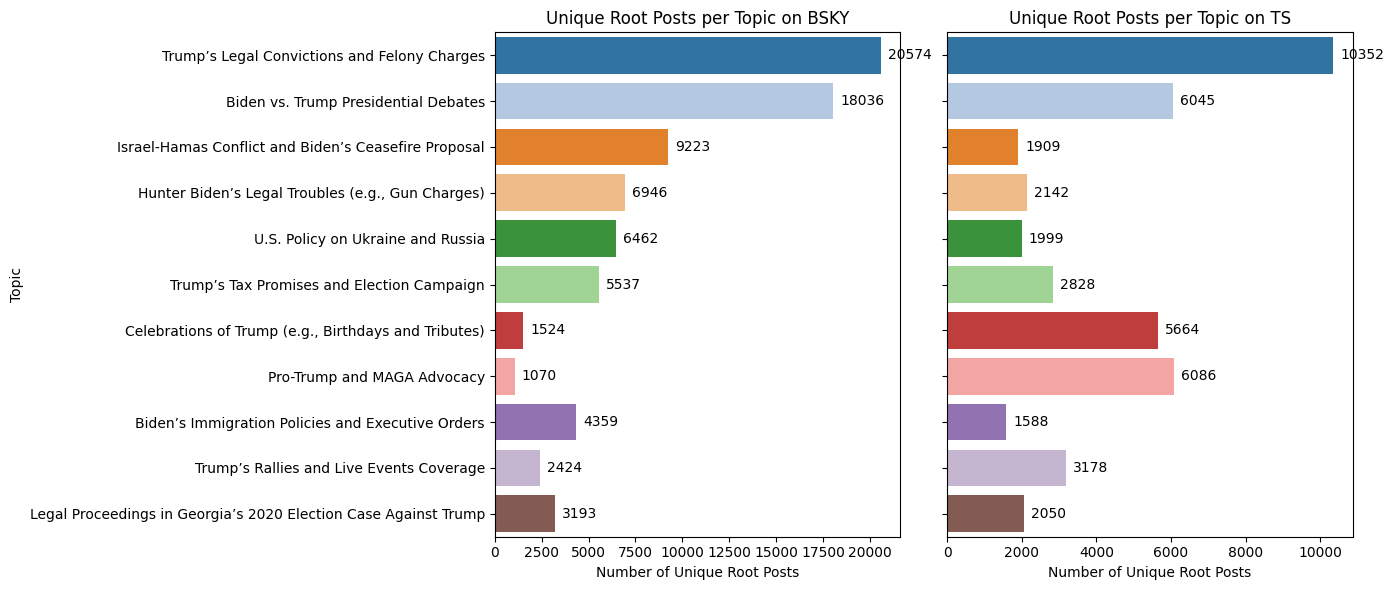

In [22]:
# Ensure consistent order of topics across both platforms
topic_order = (
    df.groupby("topic_label")["index"].nunique().sort_values(ascending=False).index
)

# Visualization of unique root posts per topic per platform
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
platforms = ["bsky", "ts"]

for idx, platform in enumerate(platforms):
    platform_data = df[df["platform"] == platform]
    root_post_counts = (
        platform_data.groupby("topic_label")["index"].nunique().reindex(topic_order)
    )

    sns.barplot(
        x=root_post_counts.values,
        y=root_post_counts.index,
        ax=axes[idx],
        palette="tab20",
    )
    axes[idx].set_title(f"Unique Root Posts per Topic on {platform.upper()}")
    axes[idx].set_xlabel("Number of Unique Root Posts")
    axes[idx].set_ylabel("Topic")

    # Add exact numbers at the end of bars, centering text properly
    for j, (value, label) in enumerate(
        zip(root_post_counts.values, root_post_counts.index)
    ):
        axes[idx].annotate(
            f"{value}",
            xy=(value, j),
            xytext=(5, 0),
            textcoords="offset points",
            va="center",
            ha="left",
            fontsize=10,
        )

plt.tight_layout()
plt.show()

### Observation
- The number of root posts under different topics on 2 platforms are different.
- Presidential debates and Trump legal convictions are two topics that have the most root posts on both platforms.
- For the rest of topics, it is clear that Truth Social is more aligned with conservative views and proporganda agenda, while Bluesky is more focus on recent policy and topcis are more diverse.


## 2. general cross-platform comparison

In [23]:
# Compute KS statistics for each metric
ks_results = []
for metric in metrics:
    bsky_vals = df[df["platform"] == "bsky"][metric].dropna()
    ts_vals = df[df["platform"] == "ts"][metric].dropna()
    ks_stat, p_value = ks_2samp(bsky_vals, ts_vals)
    ks_results.append({"Metric": metric, "KS Statistic": ks_stat, "P-value": p_value})

ks_overall_df = pd.DataFrame(ks_results)


In [6]:
# Function to compute CCDF
def empirical_ccdf(data):
    sorted_data = np.sort(data)
    ccdf = 1 - np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, ccdf

In [56]:
# Function to compare CCDF by topic
colors = plt.cm.tab20(
    np.linspace(0, 1, len(sorted(df["topic_label"].unique())))
)  # Use tab20 colormap
sorted_topics = sorted(df["topic_label"].unique())
topic_color_map = {topic: colors[i] for i, topic in enumerate(sorted_topics)}


def compare_ccdf(data, metric, ax):
    for topic in sorted_topics:  # Use sorted order
        subset = data[data["topic_label"] == topic][metric].dropna()
        sorted_vals, ccdf_vals = empirical_ccdf(subset)
        ax.plot(
            sorted_vals,
            ccdf_vals,
            label=f"{topic}",
            linewidth=2,
            color=topic_color_map[topic],
        )
    ax.set_xscale("log")  # Apply log scale to x-axis
    ax.set_yscale("log")
    ax.set_xlabel(metric)
    ax.set_ylabel("CCDF (%)")
    ax.set_title(f"CCDF of {metric} by Topic")
    ax.grid()


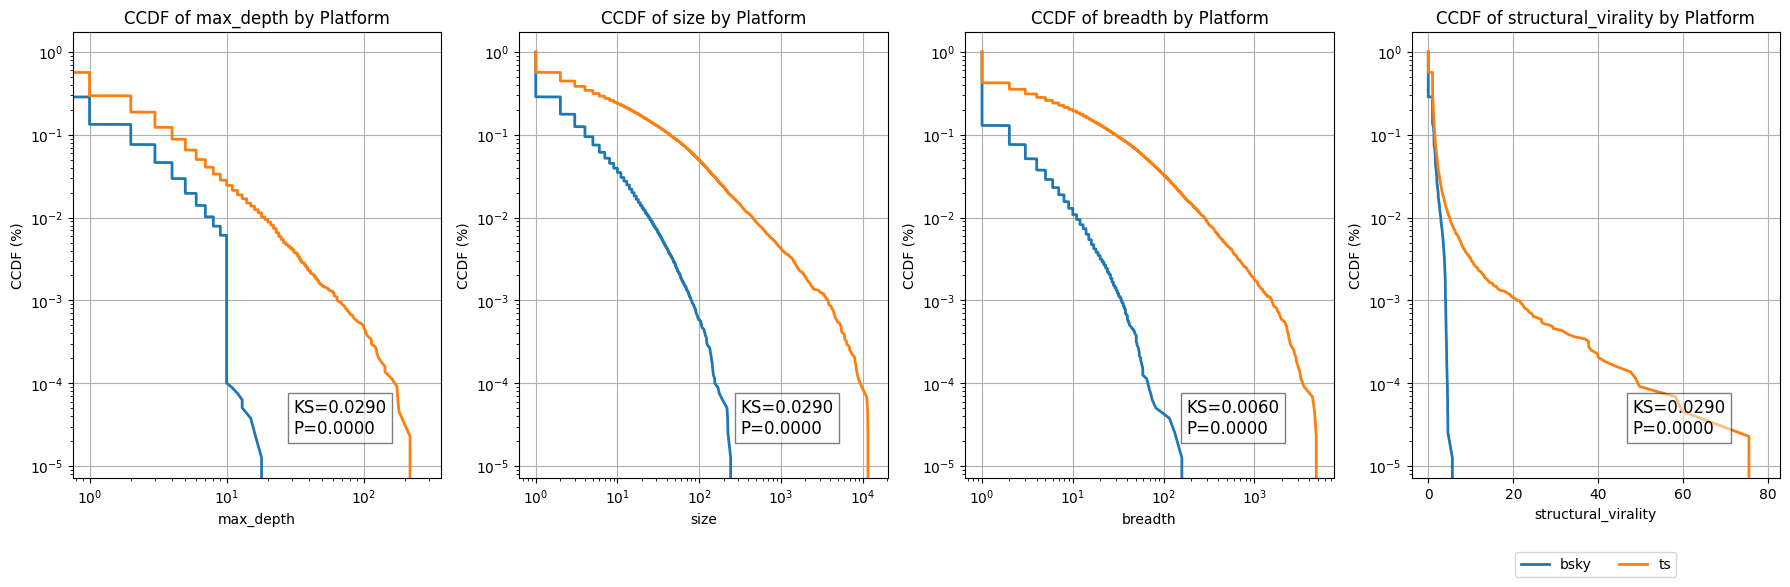

In [54]:
# Plot CCDF comparison by platform
fig, axes = plt.subplots(1, 4, figsize=(18, 6))  # 1 row, 3 columns

for idx, metric in enumerate(metrics):
    for platform in ["bsky", "ts"]:
        values = df[df["platform"] == platform][metric].dropna()
        sorted_vals = np.sort(values)
        ccdf = 1 - np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
        axes[idx].plot(sorted_vals, ccdf, label=f"{platform}", linewidth=2)

    if metric != "structural_virality":
        axes[idx].set_xscale("log")  # Apply log scale to x-axis
    axes[idx].set_yscale("log")  # Keep y-axis in log scale
    axes[idx].set_xlabel(metric)
    axes[idx].set_ylabel("CCDF (%)")
    axes[idx].set_title(f"CCDF of {metric} by Platform")
    axes[idx].grid()

    # Retrieve KS statistic and p-value
    ks_stat, p_value = ks_overall_df.loc[
        ks_overall_df["Metric"] == metric, ["KS Statistic", "P-value"]
    ].values[0]
    axes[idx].text(
        0.6,
        0.1,
        f"KS={ks_stat:.4f}\nP={p_value:.4f}",
        transform=axes[idx].transAxes,
        fontsize=12,
        bbox=dict(facecolor="white", alpha=0.5),
    )

plt.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2
)  # Move legend outside
plt.tight_layout()
plt.show()

In [27]:
df_std.max_depth.max()

NameError: name 'df_std' is not defined

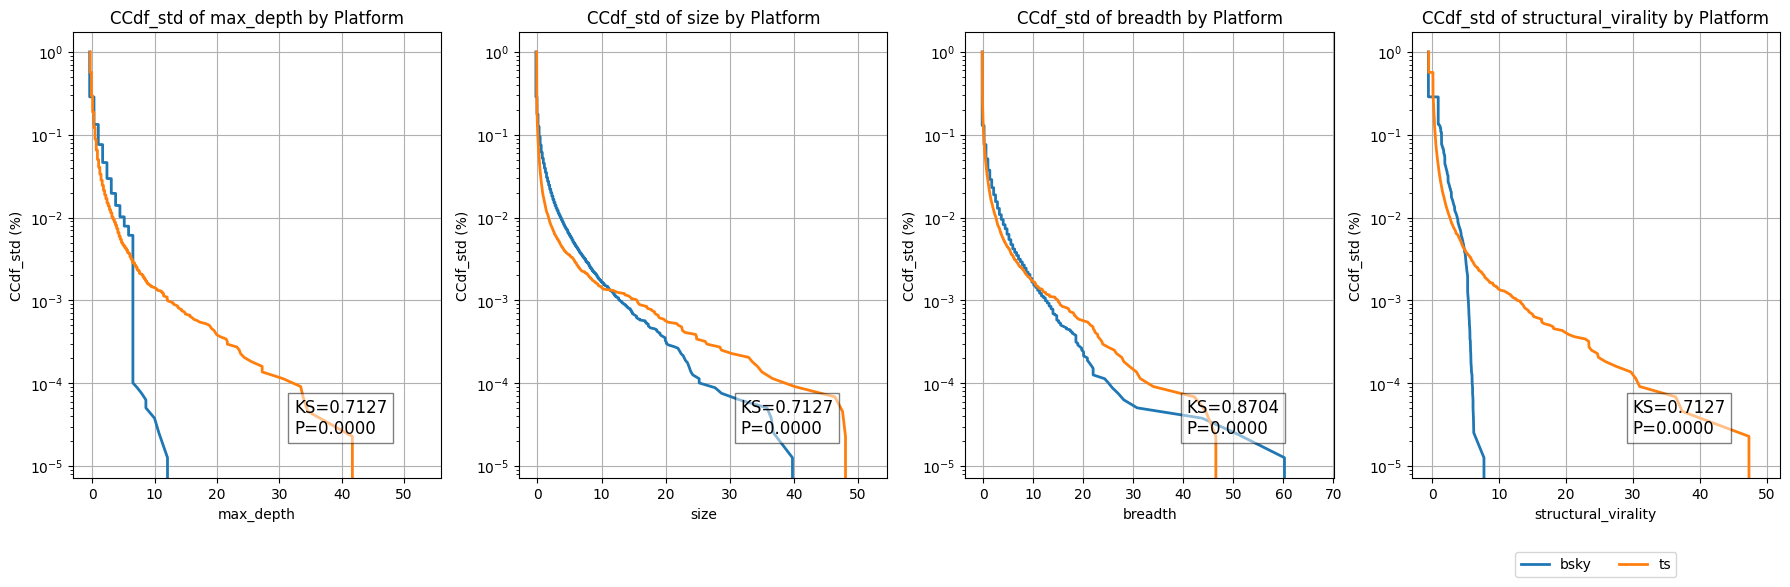

In [28]:
# Standardize the data
df_std = df.copy()
mask_bsky = df_std["platform"] == "bsky"
df_std.loc[mask_bsky, metrics] = (
    df_std.loc[mask_bsky, metrics] - df_std.loc[mask_bsky, metrics].mean()
) / df_std.loc[mask_bsky, metrics].std()

# Standardize the metrics for platform "ts"
mask_ts = df_std["platform"] == "ts"
df_std.loc[mask_ts, metrics] = (
    df_std.loc[mask_ts, metrics] - df_std.loc[mask_ts, metrics].mean()
) / df_std.loc[mask_ts, metrics].std()

# Compute KS statistics for each metric
ks_results = []
for metric in metrics:
    bsky_vals = df_std[df_std["platform"] == "bsky"][metric].dropna()
    ts_vals = df_std[df_std["platform"] == "ts"][metric].dropna()
    ks_stat, p_value = ks_2samp(bsky_vals, ts_vals)
    ks_results.append({"Metric": metric, "KS Statistic": ks_stat, "P-value": p_value})

ks_overall_df_std = pd.DataFrame(ks_results)
# Plot CCdf_std comparison by platform
fig, axes = plt.subplots(1, 4, figsize=(18, 6))  # 1 row, 3 columns

for idx, metric in enumerate(metrics):
    for platform in ["bsky", "ts"]:
        values = df_std[df_std["platform"] == platform][metric].dropna()
        sorted_vals = np.sort(values)
        ccdf_std = 1 - np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
        axes[idx].plot(sorted_vals, ccdf_std, label=f"{platform}", linewidth=2)

    # axes[idx].set_xscale("log")  # Apply log scale to x-axis
    axes[idx].set_yscale("log")  # Keep y-axis in log scale
    axes[idx].set_xlabel(metric)
    axes[idx].set_ylabel("CCdf_std (%)")
    axes[idx].set_title(f"CCdf_std of {metric} by Platform")
    axes[idx].grid()

    # Retrieve KS statistic and p-value
    ks_stat, p_value = ks_overall_df_std.loc[
        ks_overall_df_std["Metric"] == metric, ["KS Statistic", "P-value"]
    ].values[0]
    axes[idx].text(
        0.6,
        0.1,
        f"KS={ks_stat:.4f}\nP={p_value:.4f}",
        transform=axes[idx].transAxes,
        fontsize=12,
        bbox=dict(facecolor="white", alpha=0.5),
    )

plt.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2
)  # Move legend outside
plt.tight_layout()
plt.show()

## 3. general cross-topic comparison

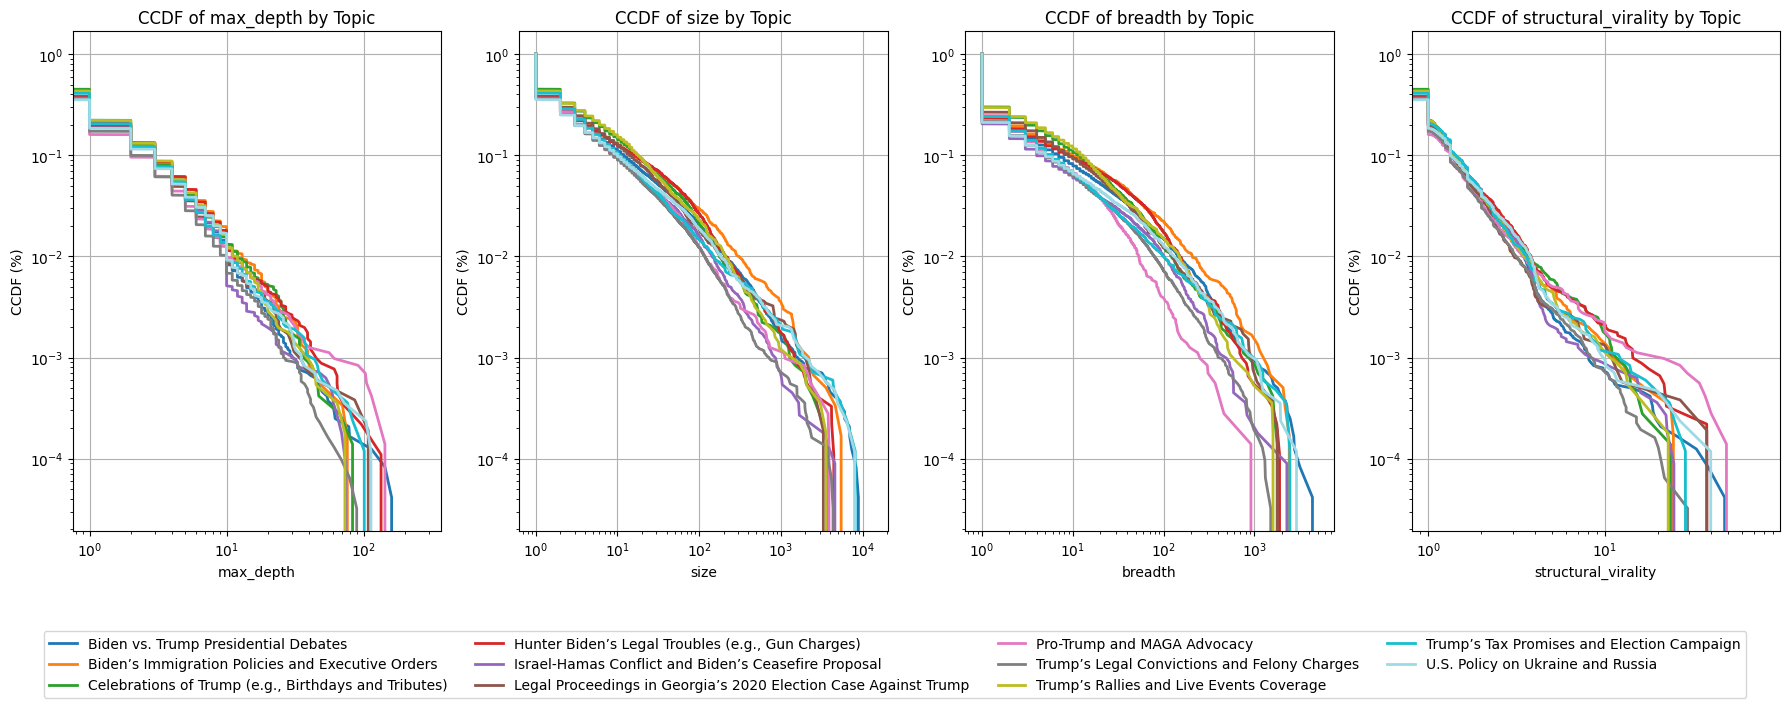

In [29]:
# Plot CCDF comparison by topic
fig, axes = plt.subplots(1, 4, figsize=(18, 6))  # 1 row, 3 columns
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    compare_ccdf(df, metric, axes[idx])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=4
)  # One legend outside

plt.tight_layout()
plt.show()


## 4. comparison by platform & by topic

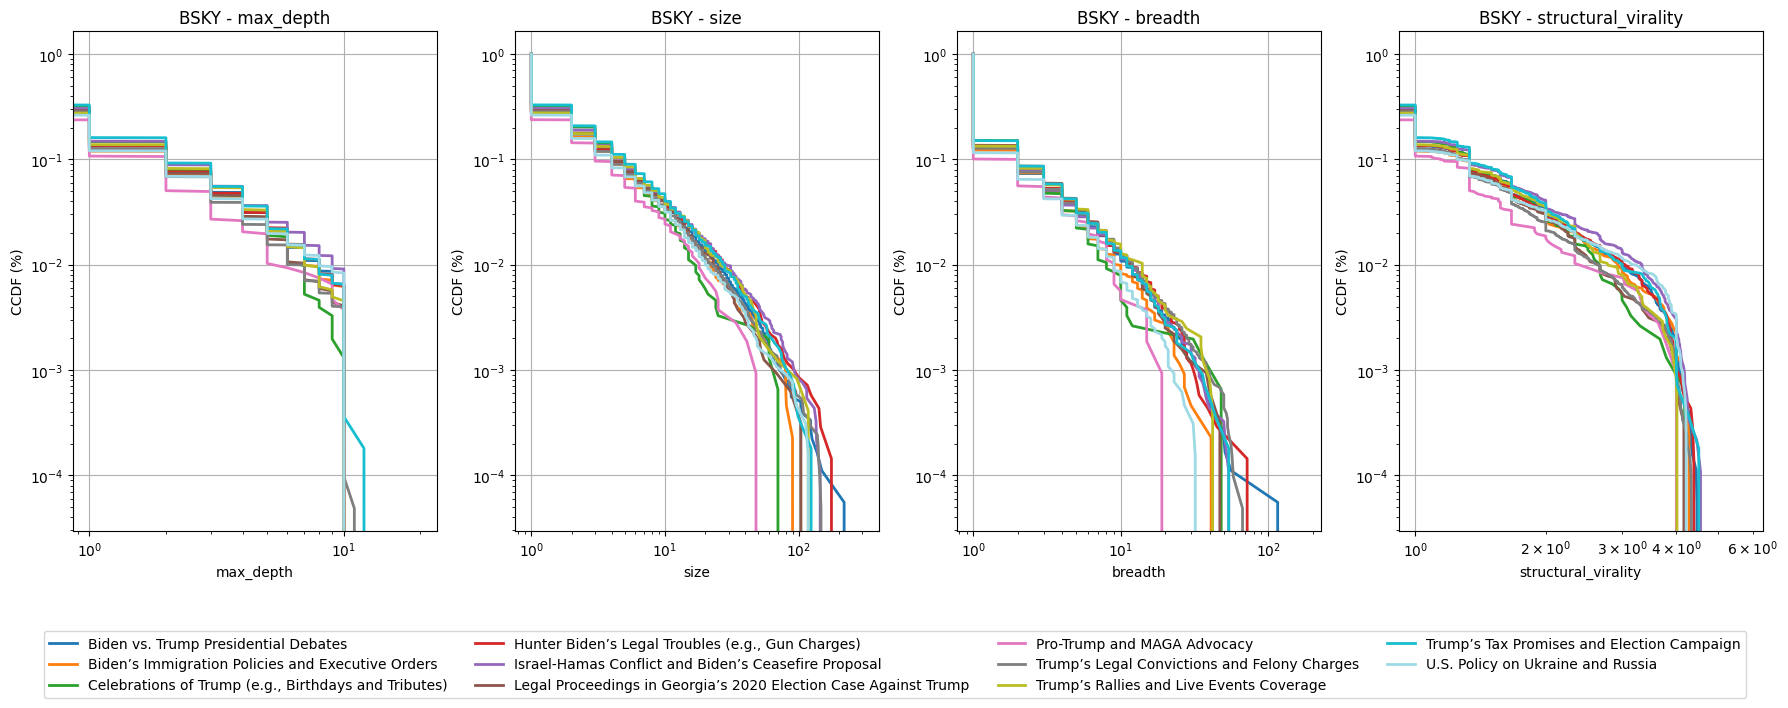

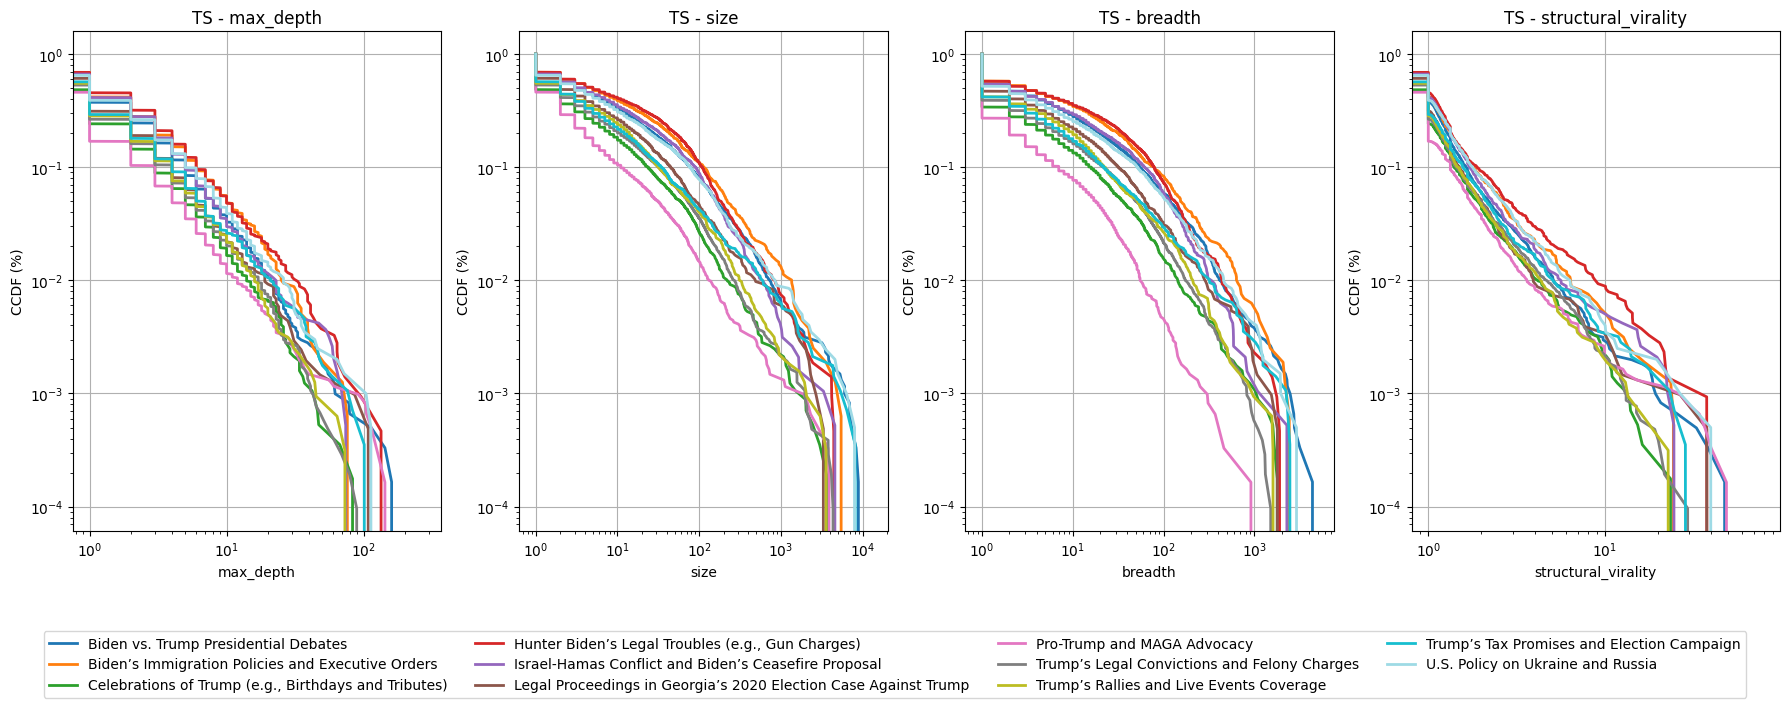

In [58]:
# Comparison by platform & by topic
for platform in ["bsky", "ts"]:
    platform_data = df[df["platform"] == platform]
    fig, axes = plt.subplots(1, 4, figsize=(18, 6))
    axes = axes.flatten()

    for idx, metric in enumerate(metrics):
        compare_ccdf(platform_data, metric, axes[idx])
        axes[idx].set_title(f"{platform.upper()} - {metric}")

    handles, labels = zip(
        *sorted(
            zip(
                axes[0].get_legend_handles_labels()[0],
                axes[0].get_legend_handles_labels()[1],
            ),
            key=lambda x: sorted_topics.index(x[1]),
        )
    )
    fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=4)

    plt.tight_layout()
    plt.show()


## 5. Quantify the difference

# B. Reposts Network

In [3]:
rp_bsky_df = pd.read_csv("../data/bsky_repost_stats.csv")
rp_ts_df = pd.read_csv("../data/ts_repost_stats.csv")

rp_ts_df.rename(columns={"topic": "topic_label"}, inplace=True)

In [4]:
rp_bsky_df.reset_index(inplace=True)

In [15]:
rp_bsky_df = rp_bsky_df[columns_to_keep].reset_index(drop=True)
rp_ts_df = rp_ts_df[columns_to_keep].reset_index(drop=True)

rp_df = pd.concat([rp_bsky_df, rp_ts_df], ignore_index=True)

rp_df = rp_df.dropna(subset=["topic_label"])


In [34]:
rp_df["topic_label"] = rp_df["topic_label"].replace(
    {"MAGA and Pro-Trump Hashtags and Advocacy": "Pro-Trump and MAGA Advocacy"}
)

rp_df = rp_df[
    rp_df["topic_label"] != "Criticism of Trump and Support for Democratic Policies"
]

## 1. Investigate number of reposts under different topics on 2 platforms

/tmp/ipykernel_820705/1939565070.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_820705/1939565070.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


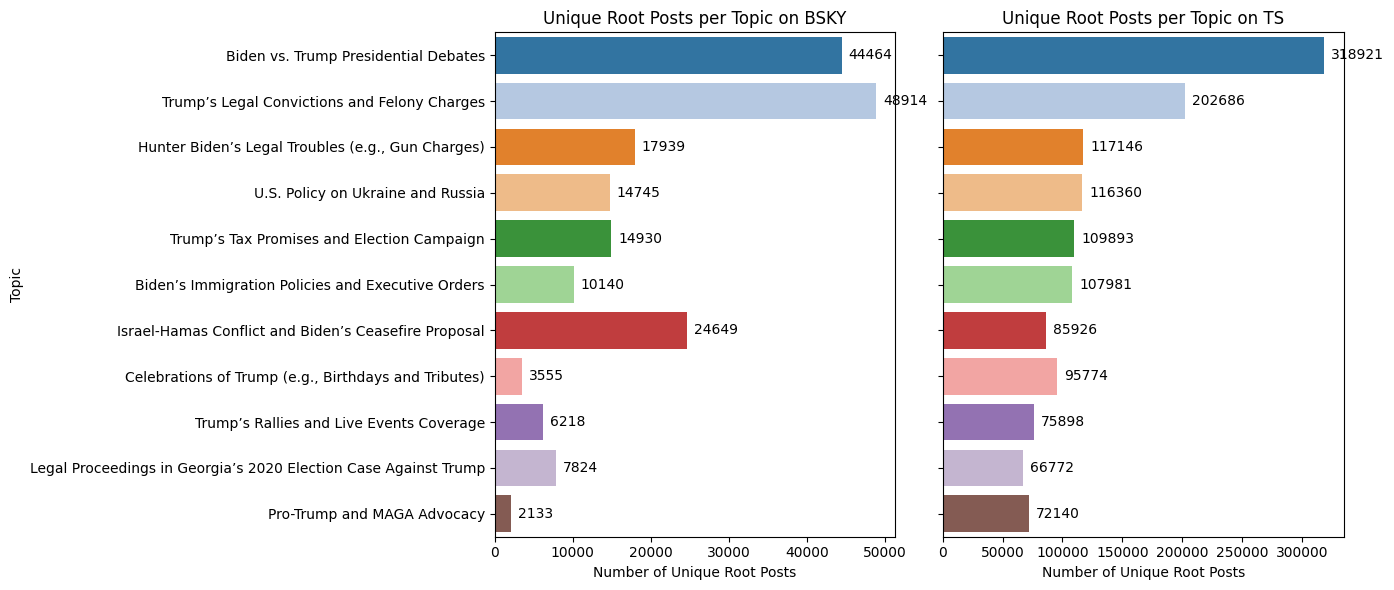

In [35]:
topic_order = (
    rp_df.groupby("topic_label")["index"].nunique().sort_values(ascending=False).index
)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
platforms = ["bsky", "ts"]

for idx, platform in enumerate(platforms):
    platform_data = rp_df[rp_df["platform"] == platform]
    root_post_counts = (
        platform_data.groupby("topic_label")["index"].nunique().reindex(topic_order)
    )

    sns.barplot(
        x=root_post_counts.values,
        y=root_post_counts.index,
        ax=axes[idx],
        palette="tab20",
    )
    axes[idx].set_title(f"Unique Root Posts per Topic on {platform.upper()}")
    axes[idx].set_xlabel("Number of Unique Root Posts")
    axes[idx].set_ylabel("Topic")

    for j, (value, label) in enumerate(
        zip(root_post_counts.values, root_post_counts.index)
    ):
        axes[idx].annotate(
            f"{value}",
            xy=(value, j),
            xytext=(5, 0),
            textcoords="offset points",
            va="center",
            ha="left",
            fontsize=10,
        )

plt.tight_layout()
plt.show()


## 2. General cross-platform comparison

In [36]:
rp_metrics = ["max_depth", "size", "breadth", "structural_virality"]

ks_results = []
for metric in rp_metrics:
    bsky_vals = rp_df[rp_df["platform"] == "bsky"][metric].dropna()
    ts_vals = rp_df[rp_df["platform"] == "ts"][metric].dropna()
    ks_stat, p_value = ks_2samp(bsky_vals, ts_vals)
    ks_results.append({"Metric": metric, "KS Statistic": ks_stat, "P-value": p_value})

ks_overall_df = pd.DataFrame(ks_results)


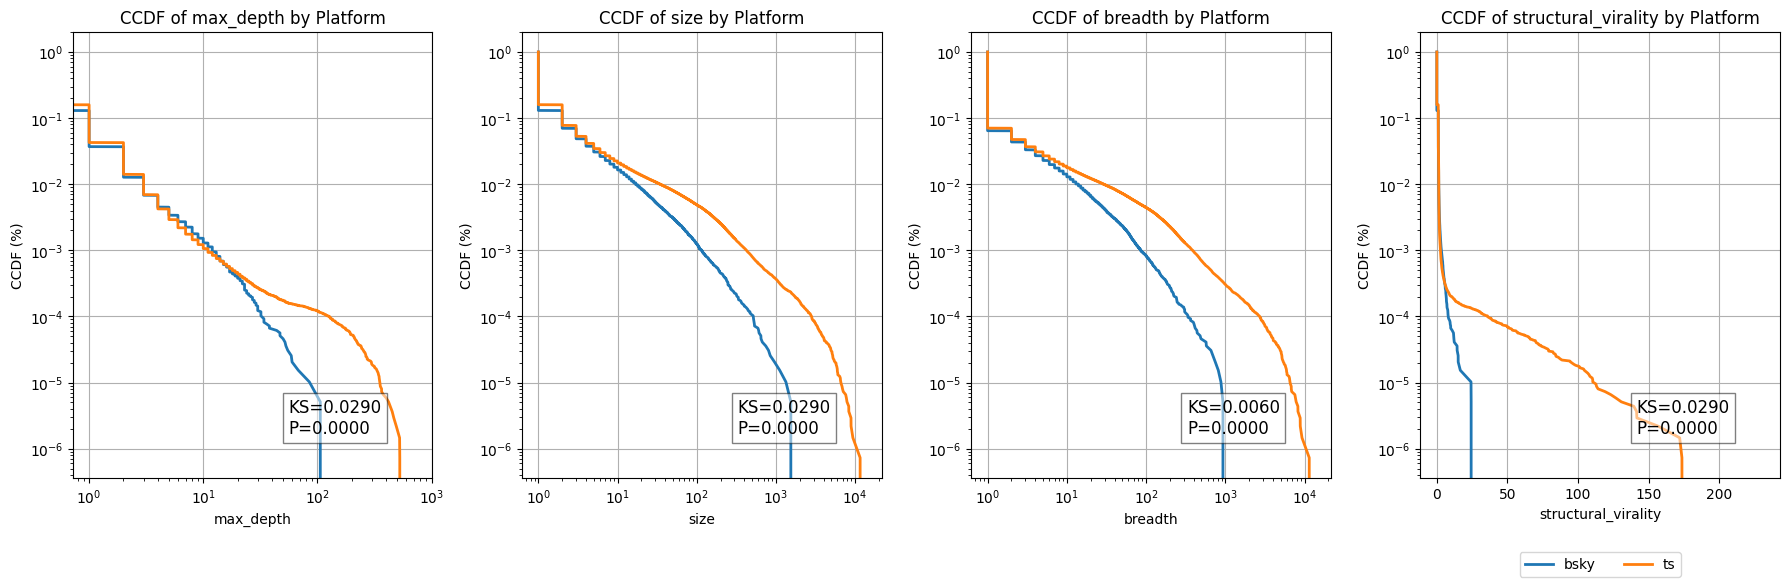

In [37]:
fig, axes = plt.subplots(1, 4, figsize=(18, 6))  # 1 row, 3 columns

for idx, metric in enumerate(rp_metrics):
    for platform in ["bsky", "ts"]:
        values = rp_df[rp_df["platform"] == platform][metric].dropna()
        sorted_vals = np.sort(values)
        ccdf = 1 - np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
        axes[idx].plot(sorted_vals, ccdf, label=f"{platform}", linewidth=2)

    if metric != "structural_virality":
        axes[idx].set_xscale("log")  # Apply log scale to x-axis
    axes[idx].set_yscale("log")  # Keep y-axis in log scale
    axes[idx].set_xlabel(metric)
    axes[idx].set_ylabel("CCDF (%)")
    axes[idx].set_title(f"CCDF of {metric} by Platform")
    axes[idx].grid()

    ks_stat, p_value = ks_overall_df.loc[
        ks_overall_df["Metric"] == metric, ["KS Statistic", "P-value"]
    ].values[0]
    axes[idx].text(
        0.6,
        0.1,
        f"KS={ks_stat:.4f}\nP={p_value:.4f}",
        transform=axes[idx].transAxes,
        fontsize=12,
        bbox=dict(facecolor="white", alpha=0.5),
    )

plt.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2
)  # Move legend outside
plt.tight_layout()
plt.show()


## 3. General cross-topic comparison

In [62]:
plt.figure(rows=2, cols=1)
plt.scatter(rp_bsky_df["max_depth"], rp_bsky_df["size"])
plt.scatter(rp_ts_df["max_depth"], rp_ts_df["size"])
plt.show()

AttributeError: Figure.set() got an unexpected keyword argument 'rows'

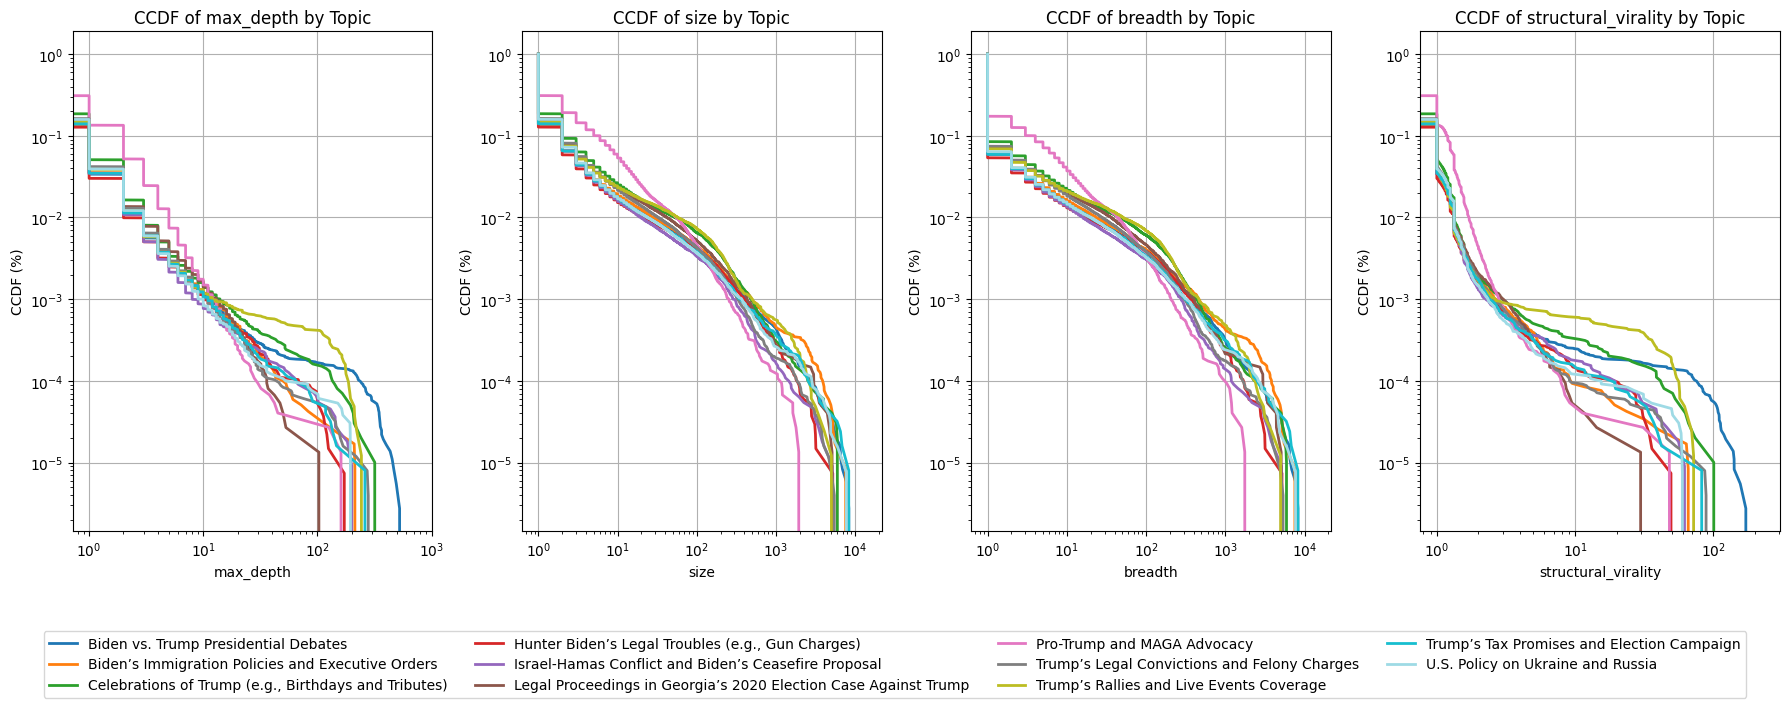

In [40]:
# Plot CCDF comparison by topic
fig, axes = plt.subplots(1, 4, figsize=(18, 6))  # 1 row, 3 columns
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    compare_ccdf(rp_df, metric, axes[idx])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=4
)  # One legend outside

plt.tight_layout()
plt.show()


## 4. Comparison by platform & by topic

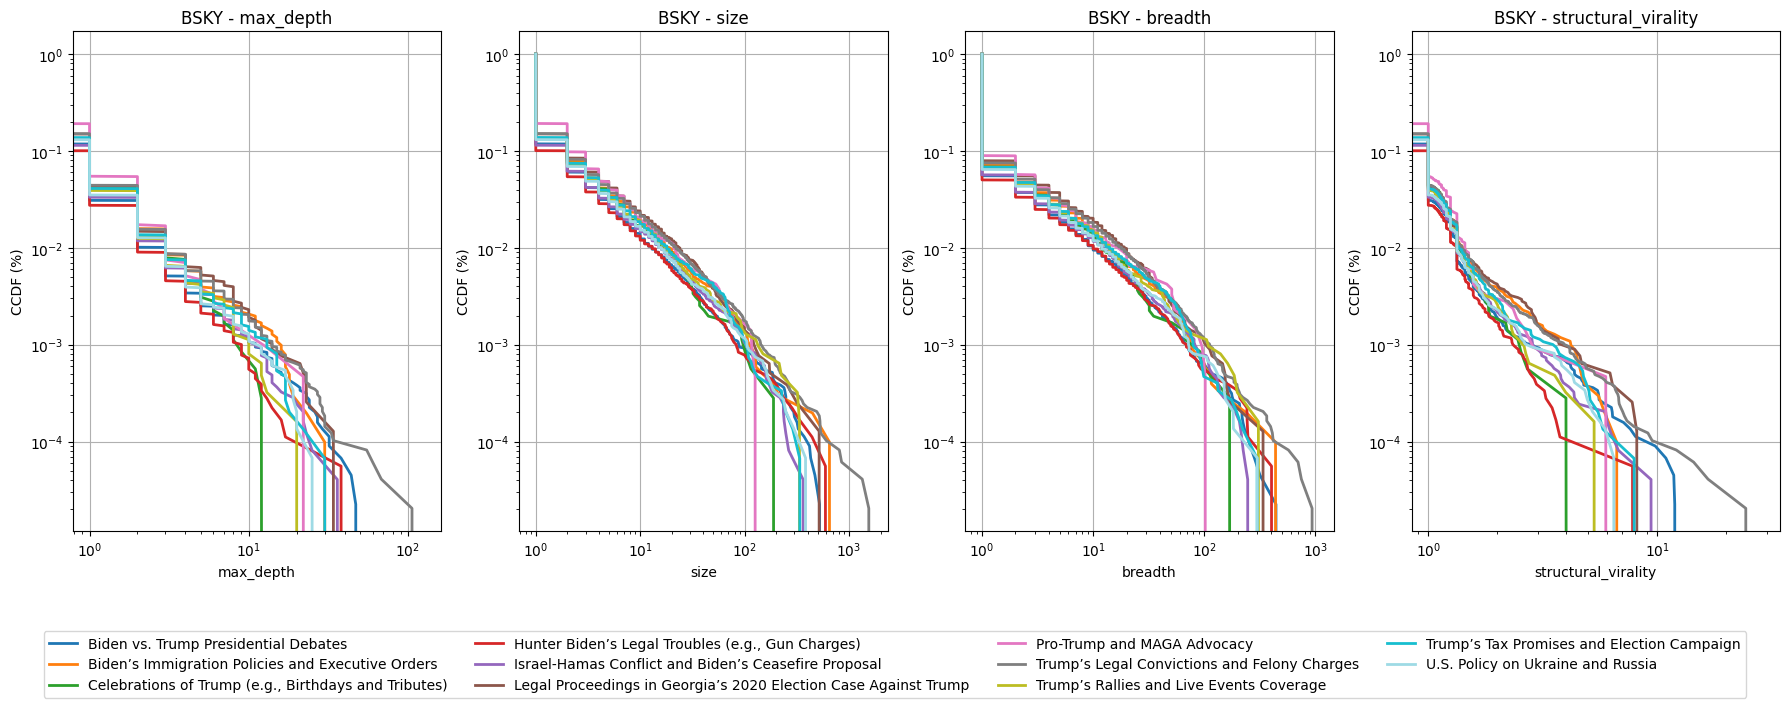

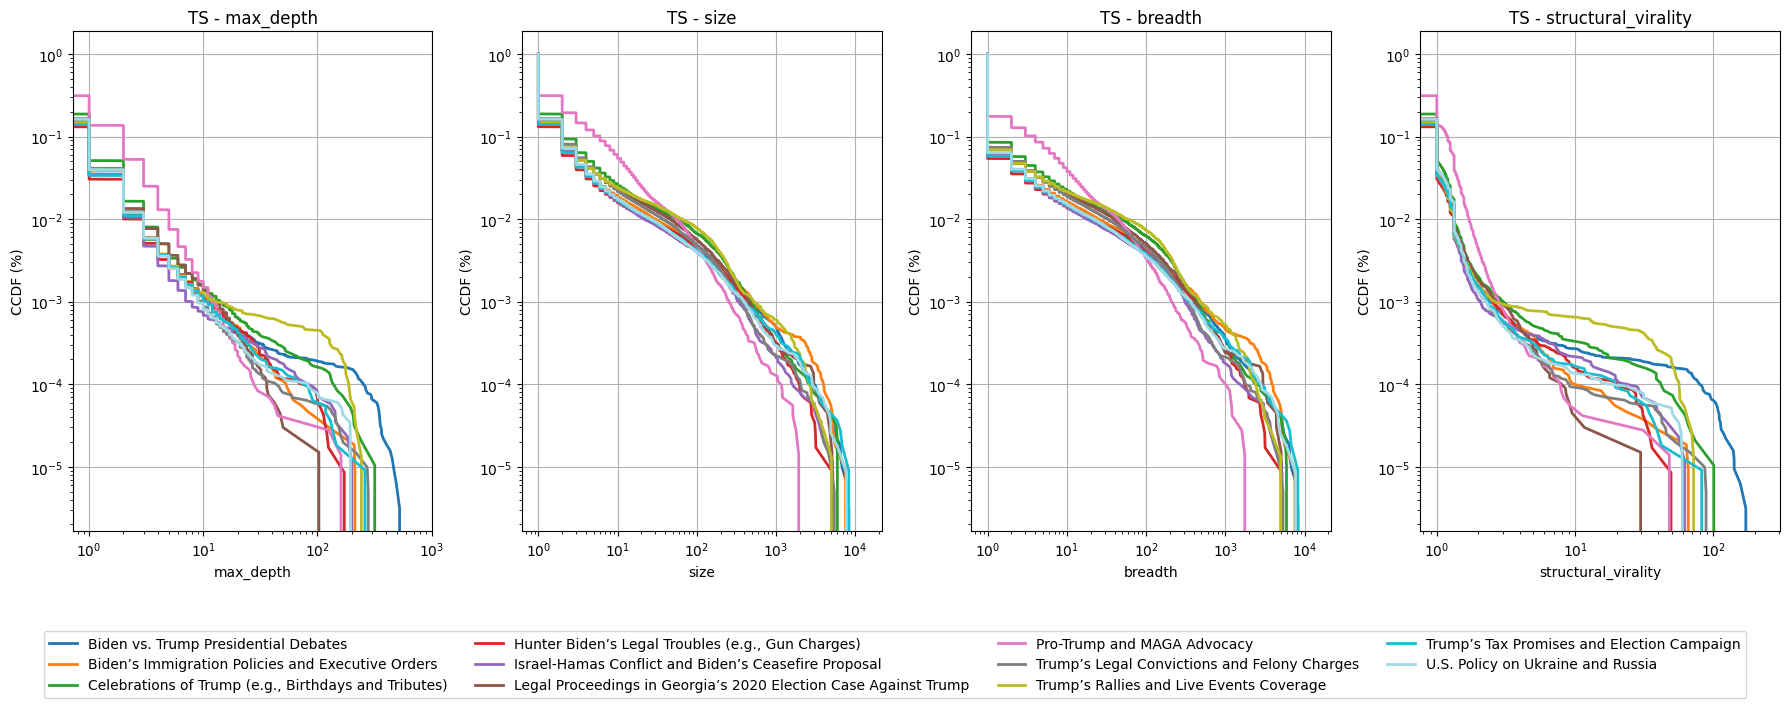

In [57]:
# Comparison by platform & by topic
for platform in ["bsky", "ts"]:
    platform_data = rp_df[rp_df["platform"] == platform]
    fig, axes = plt.subplots(1, 4, figsize=(18, 6))
    axes = axes.flatten()

    for idx, metric in enumerate(metrics):
        compare_ccdf(platform_data, metric, axes[idx])
        axes[idx].set_title(f"{platform.upper()} - {metric}")

    handles, labels = zip(
        *sorted(
            zip(
                axes[0].get_legend_handles_labels()[0],
                axes[0].get_legend_handles_labels()[1],
            ),
            key=lambda x: sorted_topics.index(x[1]),
        )
    )
    fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=4)

    plt.tight_layout()
    plt.show()

# C. Combined Network

In [44]:
c_bsky_df = pd.read_csv("../data/bsky_combined_stats.csv")
c_ts_df = pd.read_csv("../data/ts_combined_stats.csv")

c_ts_df.rename(columns={"topic": "topic_label"}, inplace=True)

In [45]:
c_bsky_df = c_bsky_df[columns_to_keep].reset_index(drop=True)
c_ts_df = c_ts_df[columns_to_keep].reset_index(drop=True)

c_df = pd.concat([c_bsky_df, c_ts_df], ignore_index=True)
c_df = c_df.dropna(subset=["topic_label"])

In [46]:
# Merge similar topics
c_df["topic_label"] = c_df["topic_label"].replace(
    {"MAGA and Pro-Trump Hashtags and Advocacy": "Pro-Trump and MAGA Advocacy"}
)

In [47]:
# Drop specified topic
c_df = c_df[
    c_df["topic_label"] != "Criticism of Trump and Support for Democratic Policies"
]

## 1. Investigate number of root posts under different topics on 2 platforms

/tmp/ipykernel_820705/2526492421.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_820705/2526492421.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


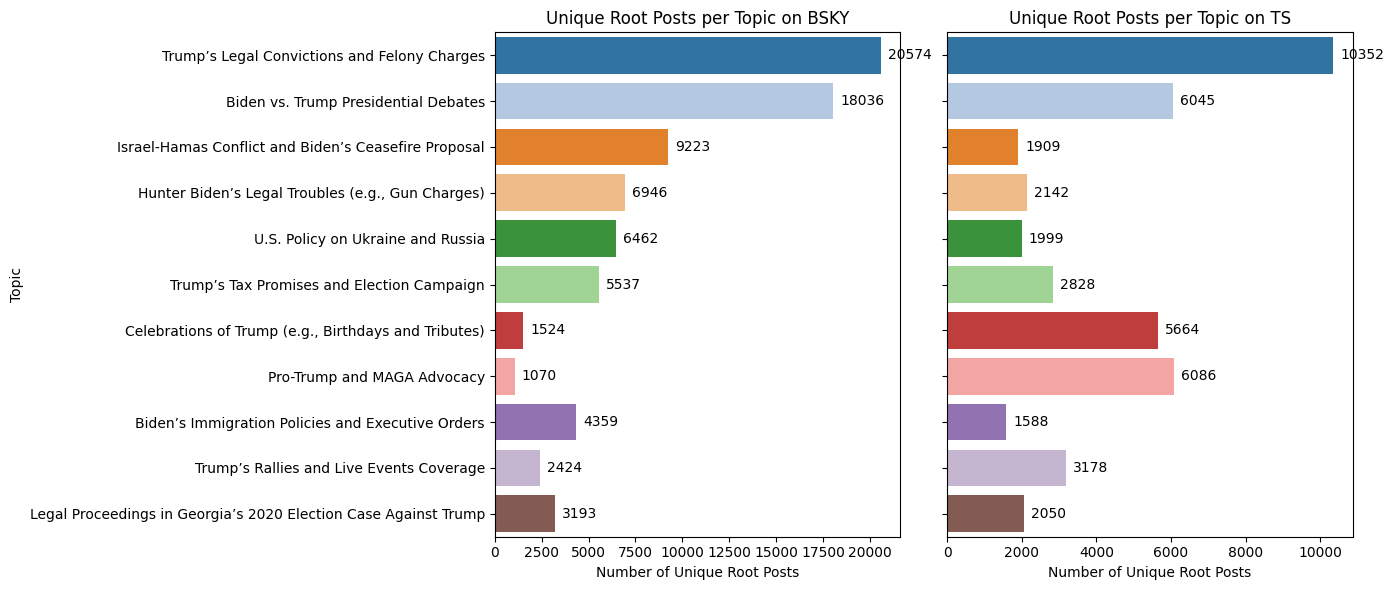

In [48]:
# Ensure consistent order of topics across both platforms
topic_order = (
    c_df.groupby("topic_label")["index"].nunique().sort_values(ascending=False).index
)

# Visualization of unique root posts per topic per platform
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
platforms = ["bsky", "ts"]

for idx, platform in enumerate(platforms):
    platform_data = df[df["platform"] == platform]
    root_post_counts = (
        platform_data.groupby("topic_label")["index"].nunique().reindex(topic_order)
    )

    sns.barplot(
        x=root_post_counts.values,
        y=root_post_counts.index,
        ax=axes[idx],
        palette="tab20",
    )
    axes[idx].set_title(f"Unique Root Posts per Topic on {platform.upper()}")
    axes[idx].set_xlabel("Number of Unique Root Posts")
    axes[idx].set_ylabel("Topic")

    # Add exact numbers at the end of bars, centering text properly
    for j, (value, label) in enumerate(
        zip(root_post_counts.values, root_post_counts.index)
    ):
        axes[idx].annotate(
            f"{value}",
            xy=(value, j),
            xytext=(5, 0),
            textcoords="offset points",
            va="center",
            ha="left",
            fontsize=10,
        )

plt.tight_layout()
plt.show()

## 2. general cross-platform comparison

In [49]:
# Compute KS statistics for each metric
c_ks_results = []
for metric in metrics:
    c_bsky_vals = c_df[c_df["platform"] == "bsky"][metric].dropna()
    c_ts_vals = c_df[c_df["platform"] == "ts"][metric].dropna()
    c_ks_stat, c_p_value = ks_2samp(c_bsky_vals, c_ts_vals)
    c_ks_results.append(
        {"Metric": metric, "KS Statistic": c_ks_stat, "P-value": c_p_value}
    )

c_ks_overall_df = pd.DataFrame(c_ks_results)

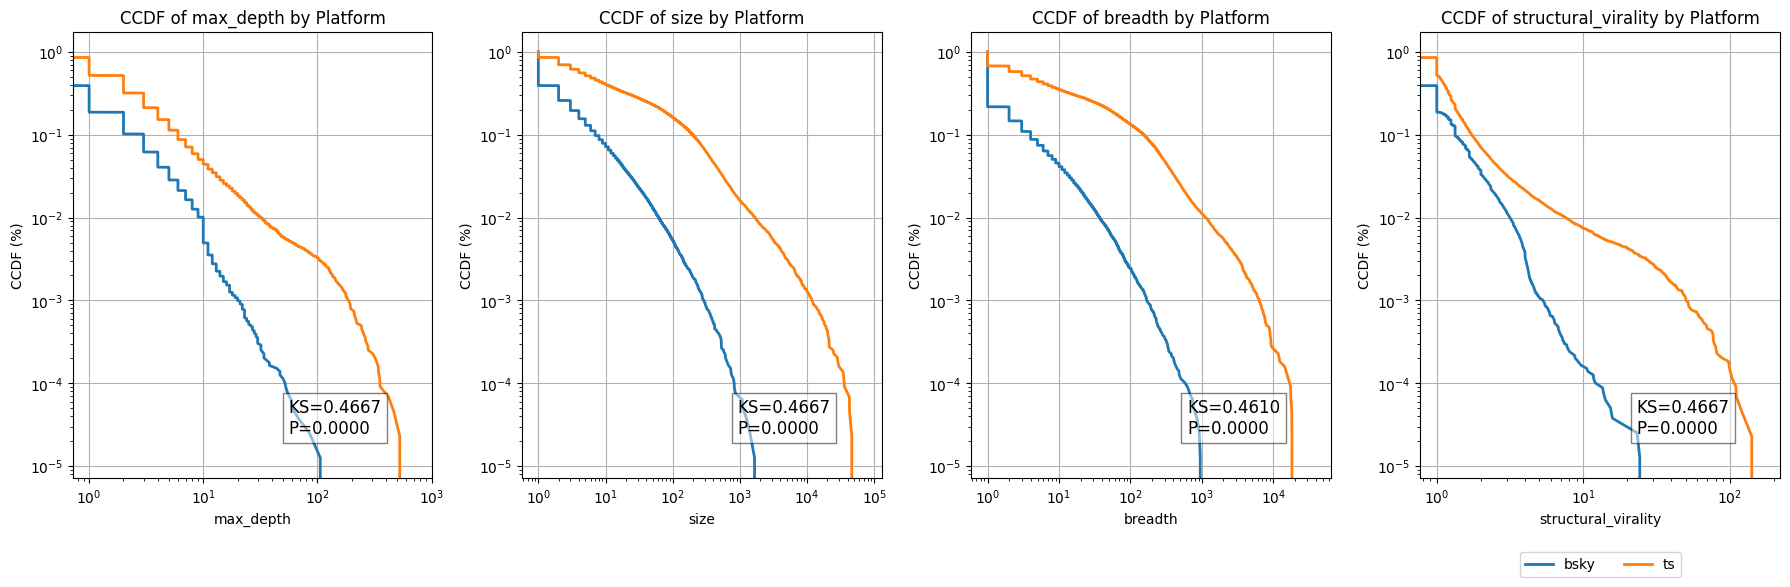

In [50]:
# Plot CCDF comparison by platform
fig, axes = plt.subplots(1, 4, figsize=(18, 6))  # 1 row, 3 columns

for idx, metric in enumerate(metrics):
    for platform in ["bsky", "ts"]:
        values = c_df[c_df["platform"] == platform][metric].dropna()
        sorted_vals = np.sort(values)
        ccdf = 1 - np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
        axes[idx].plot(sorted_vals, ccdf, label=f"{platform}", linewidth=2)

    axes[idx].set_xscale("log")  # Apply log scale to x-axis
    axes[idx].set_yscale("log")  # Keep y-axis in log scale
    axes[idx].set_xlabel(metric)
    axes[idx].set_ylabel("CCDF (%)")
    axes[idx].set_title(f"CCDF of {metric} by Platform")
    axes[idx].grid()

    # Retrieve KS statistic and p-value
    c_ks_stat, p_value = c_ks_overall_df.loc[
        c_ks_overall_df["Metric"] == metric, ["KS Statistic", "P-value"]
    ].values[0]
    axes[idx].text(
        0.6,
        0.1,
        f"KS={c_ks_stat:.4f}\nP={p_value:.4f}",
        transform=axes[idx].transAxes,
        fontsize=12,
        bbox=dict(facecolor="white", alpha=0.5),
    )

plt.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2
)  # Move legend outside
plt.tight_layout()
plt.show()

## 3. general cross-topic comparison

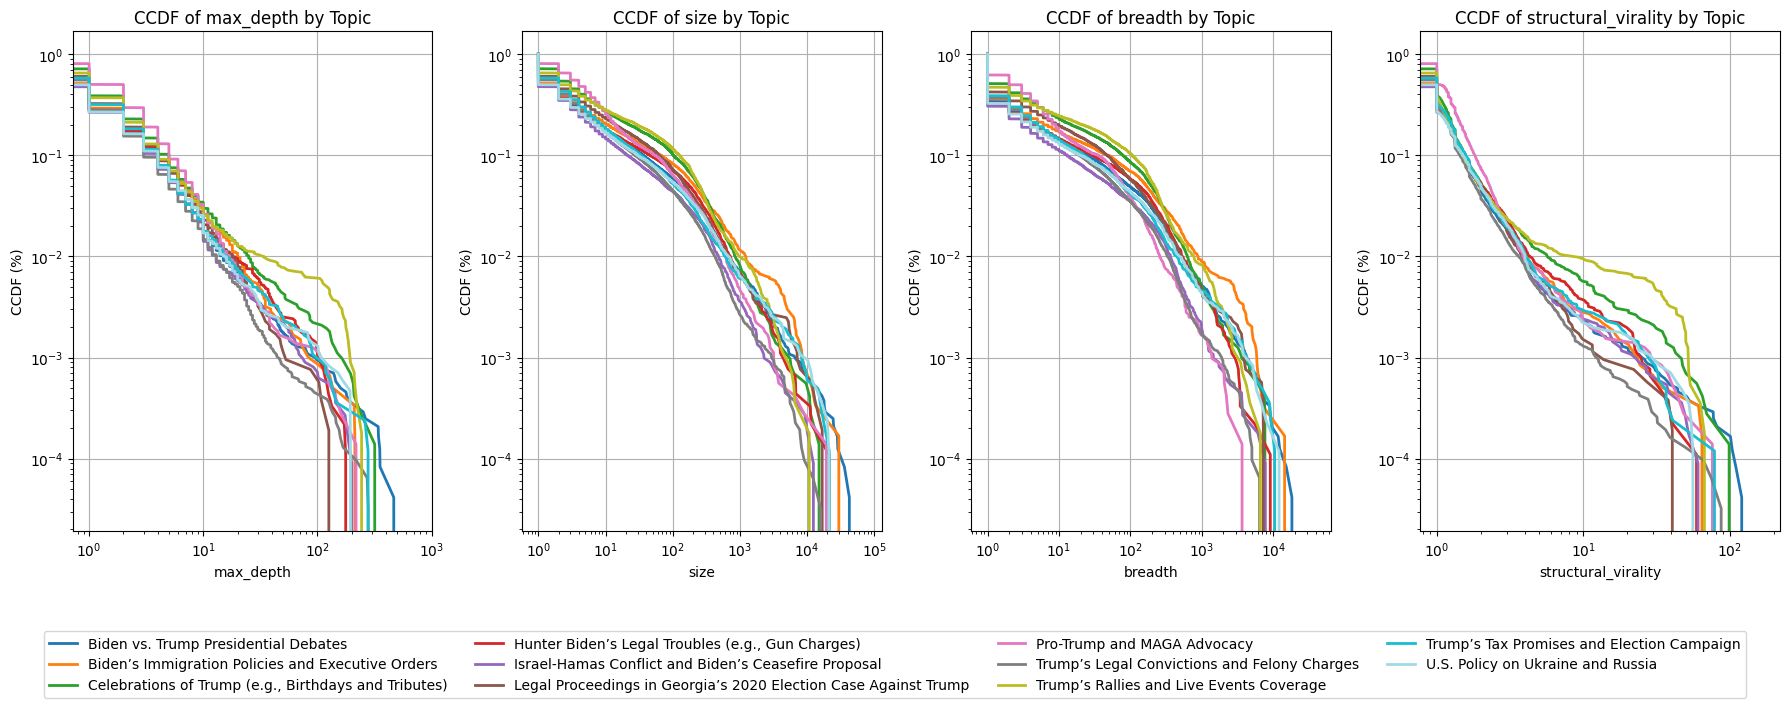

In [51]:
# Plot CCDF comparison by topic
fig, axes = plt.subplots(1, 4, figsize=(18, 6))  # 1 row, 3 columns
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    compare_ccdf(c_df, metric, axes[idx])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=4
)  # One legend outside

plt.tight_layout()
plt.show()


## 4. comparison by platform & by topic

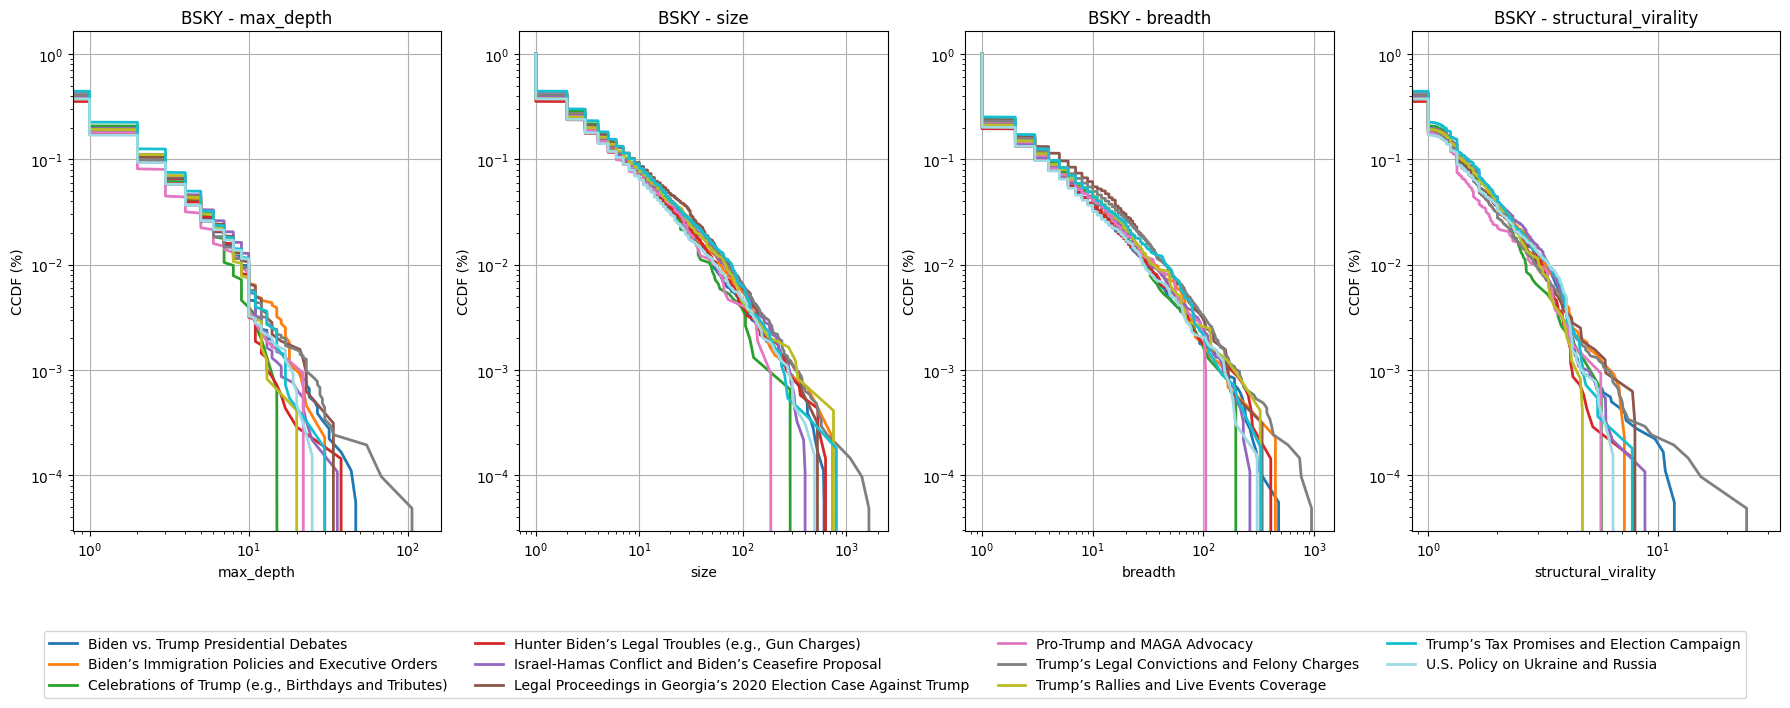

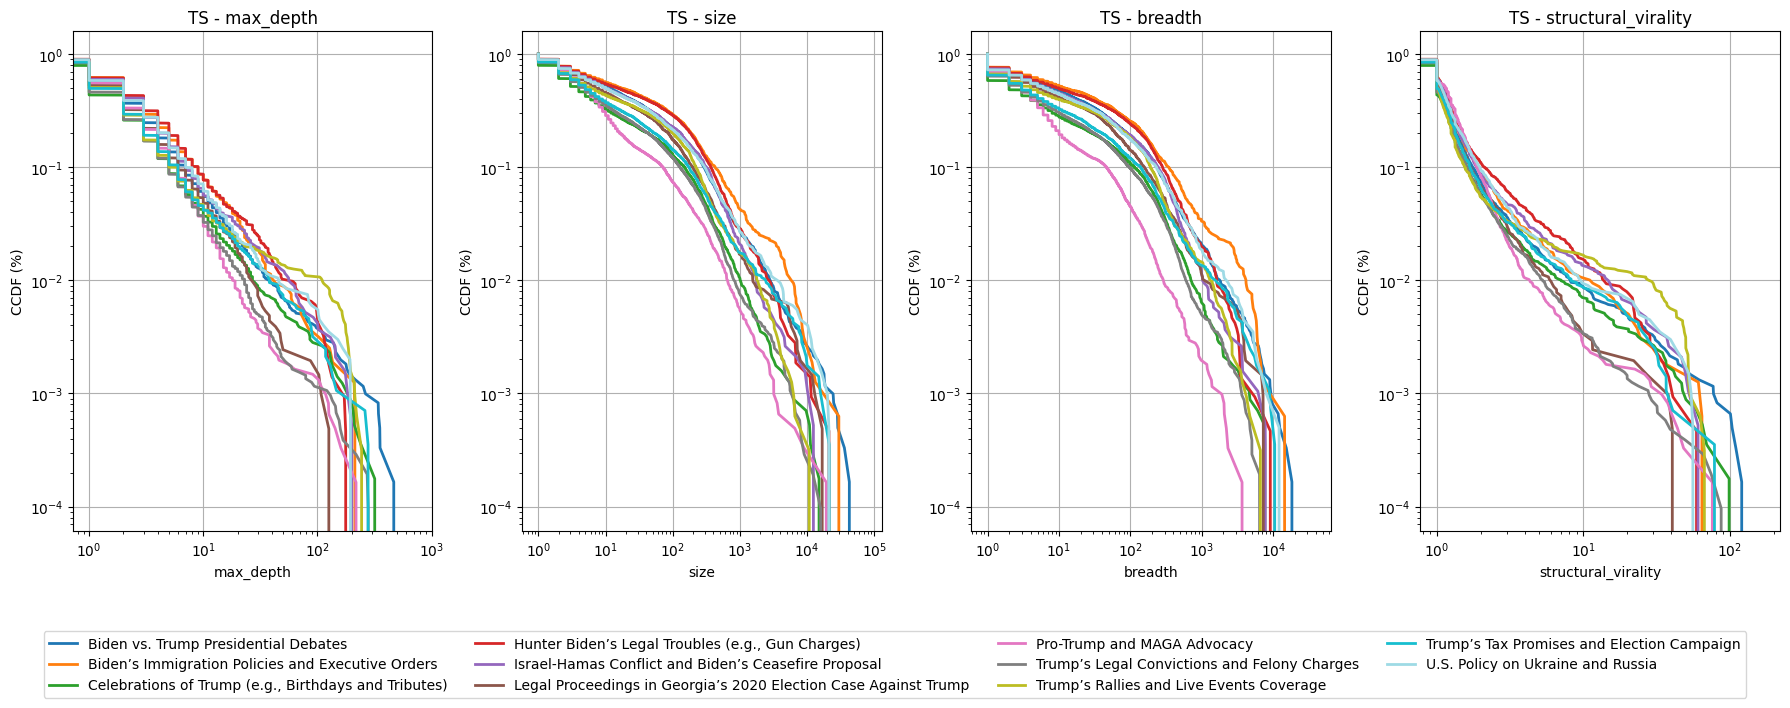

In [52]:
# Comparison by platform & by topic
for platform in ["bsky", "ts"]:
    platform_data = c_df[c_df["platform"] == platform]
    fig, axes = plt.subplots(1, 4, figsize=(18, 6))
    axes = axes.flatten()

    for idx, metric in enumerate(metrics):
        compare_ccdf(platform_data, metric, axes[idx])
        axes[idx].set_title(f"{platform.upper()} - {metric}")

    handles, labels = zip(
        *sorted(
            zip(
                axes[0].get_legend_handles_labels()[0],
                axes[0].get_legend_handles_labels()[1],
            ),
            key=lambda x: sorted_topics.index(x[1]),
        )
    )
    fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=4)

    plt.tight_layout()
    plt.show()

# Summary

1. Topic-wise comparison: Truth Social is more aligned with conservative views and proporganda agenda, while Bluesky is more focus on recent policy and topcis are more diverse.
2. Topic-wise ccdf: 
    1. Reply network: most salient distribution for BlueSky is from presidential debates and same for Truth Social.
    2. Repost network: most salient distribution for BlueSky is from Trump's legal convictions and For Truth Social, it is from presidential debates.
    3. Combined network: as same as repost network, but the Truth Social phenomenon is more pronounced.
3. 191575 out of 747571 for ts and 23138 out of 59813 

# D. Matching the cascades across platforms

## 1. Understand the relationship between the size and other metrics

In [18]:
# log the size for bsky_df and ts_df
bsky_df["log_size"] = np.log(bsky_df["size"])
ts_df["log_size"] = np.log(ts_df["size"])
rp_bsky_df["log_size"] = np.log(rp_bsky_df["size"])
rp_ts_df["log_size"] = np.log(rp_ts_df["size"])


In [19]:
# using scatter plot to compare the size of the reposts and the original posts

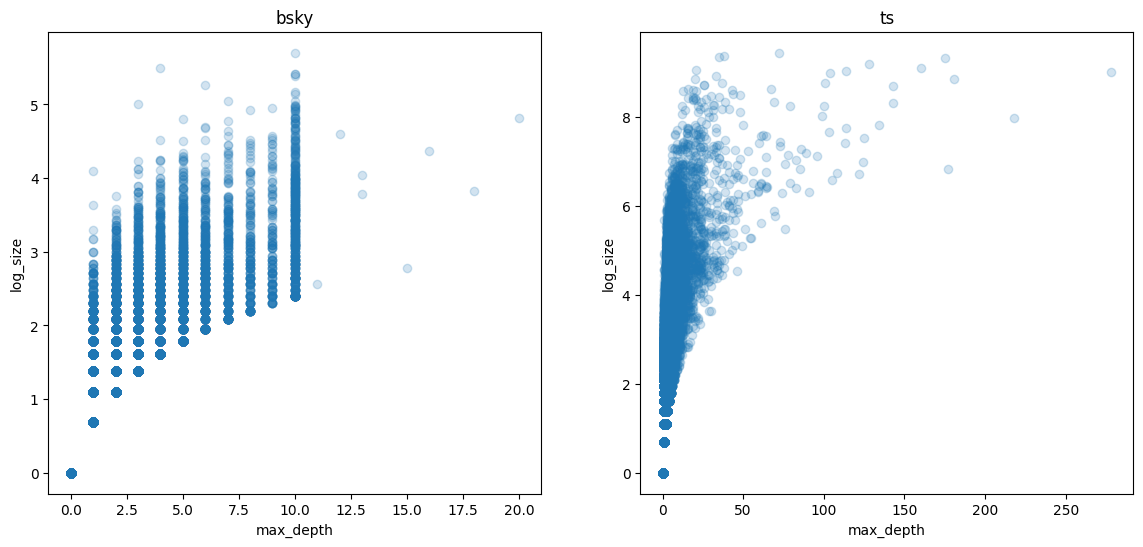

In [ ]:
# Plot the scatter plot for size and depth for seperate figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].scatter(bsky_df["max_depth"], bsky_df["log_size"], label="bsky", alpha=0.2)
axes[1].scatter(ts_df["max_depth"], ts_df["log_size"], label="ts", alpha=0.2)
axes[0].set_xlabel("max_depth")
axes[0].set_ylabel("log_size")
axes[1].set_xlabel("max_depth")
axes[1].set_ylabel("log_size")
axes[0].set_title("bsky")
axes[1].set_title("ts")
plt.show()


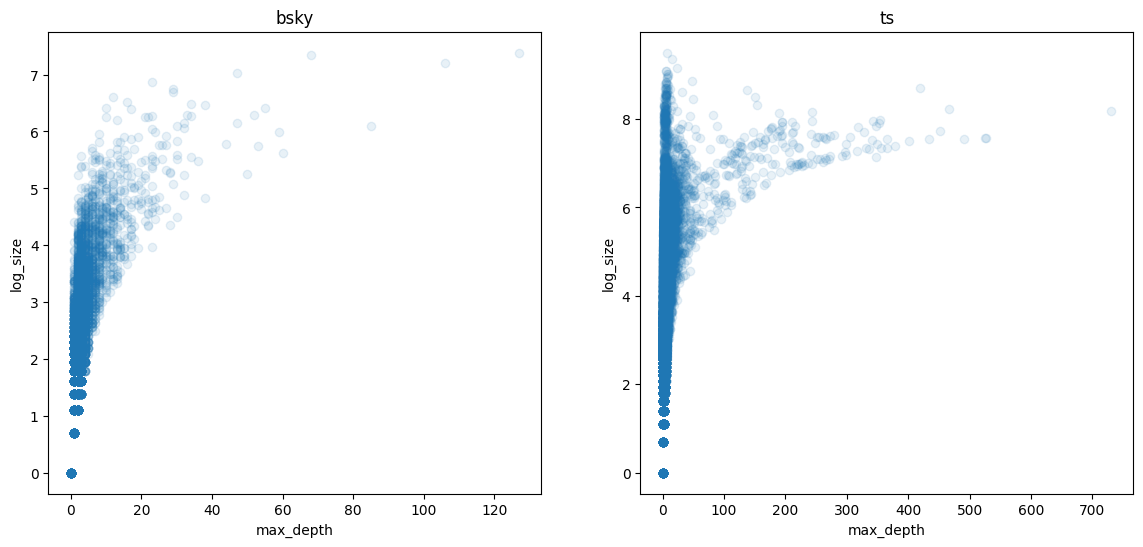

In [ ]:
# Plot the scatter plot for depth and size for seperate figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].scatter(
    rp_bsky_df["max_depth"], rp_bsky_df["log_size"], label="bsky", alpha=0.1
)
axes[1].scatter(rp_ts_df["max_depth"], rp_ts_df["log_size"], label="ts", alpha=0.1)
axes[0].set_xlabel("max_depth")
axes[0].set_ylabel("log_size")
axes[1].set_xlabel("max_depth")
axes[1].set_ylabel("log_size")
axes[0].set_title("bsky")
axes[1].set_title("ts")
plt.show()


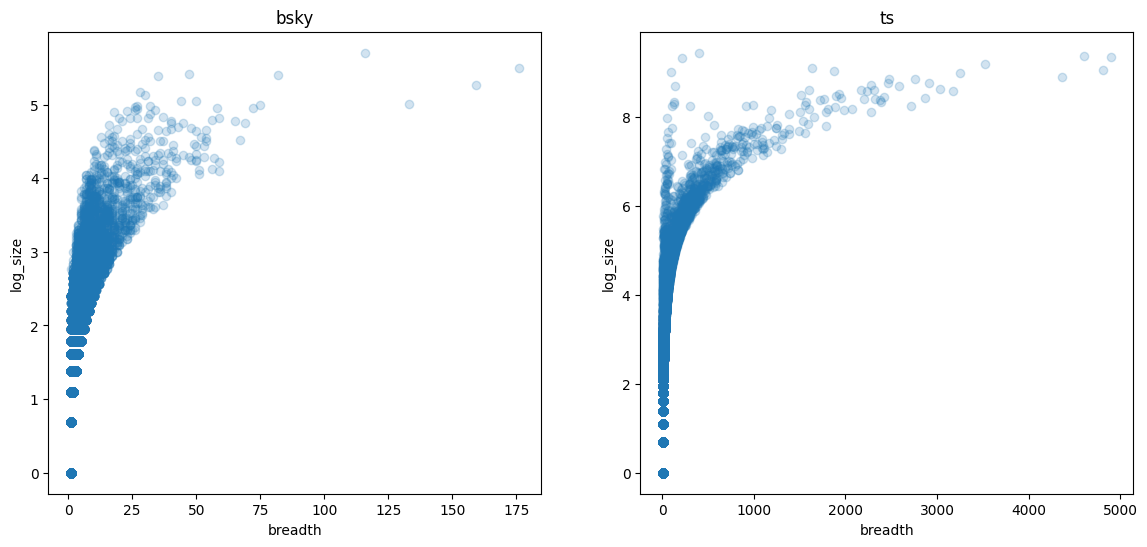

In [ ]:
# breath and size
# Plot the scatter plot for size and depth for seperate figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].scatter(bsky_df["breadth"], bsky_df["log_size"], label="bsky", alpha=0.2)
axes[1].scatter(ts_df["breadth"], ts_df["log_size"], label="ts", alpha=0.2)
axes[0].set_xlabel("breadth")
axes[0].set_ylabel("log_size")
axes[1].set_xlabel("breadth")
axes[1].set_ylabel("log_size")
axes[0].set_title("bsky")
axes[1].set_title("ts")
plt.show()


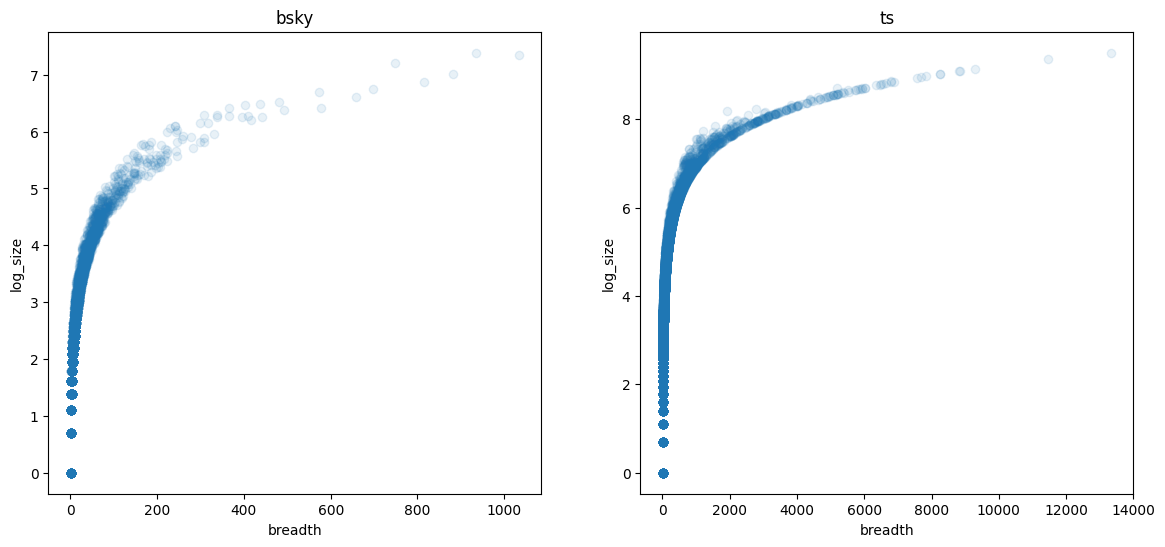

In [36]:
# Plot the scatter plot for depth and size for seperate figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].scatter(rp_bsky_df["breadth"], rp_bsky_df["log_size"], label="bsky", alpha=0.1)
axes[1].scatter(rp_ts_df["breadth"], rp_ts_df["log_size"], label="ts", alpha=0.1)
axes[0].set_xlabel("breadth")
axes[0].set_ylabel("log_size")
axes[1].set_xlabel("breadth")
axes[1].set_ylabel("log_size")
axes[0].set_title("bsky")
axes[1].set_title("ts")
plt.show()

In [6]:
len(ts_df)

43818

In [22]:
import numpy as np
import pandas as pd
import random
from collections import defaultdict

# Sort ts_df by size for efficient binary search
ts_df = ts_df.sort_values("size").reset_index()
bsky_df = bsky_df.sort_values("size").reset_index(drop=True)

# Convert DataFrames to NumPy arrays for fast operations
bsky_sizes = bsky_df["size"].to_numpy()
ts_sizes = ts_df["size"].to_numpy()
ts_indices = ts_df.index.to_numpy()  # Store original indices

# Store indices of matched records instead of full row data
matched_indices = []
unmatched_size = set()

# Track available indices for each size (handles duplicates)
size_to_indices = defaultdict(list)
for i, size in enumerate(ts_sizes):
    size_to_indices[size].append(ts_indices[i])  # Store index for sampling

# Fast lookup using NumPy binary search
for size in bsky_sizes:
    idx = np.searchsorted(ts_sizes, size)  # Find closest match index

    # Get nearest neighbor within tolerance
    possible_matches = size_to_indices.get(ts_sizes[idx], [])

    # If valid matches are found, sample one
    if possible_matches:
        matched_indices.append(
            random.choice(possible_matches)
        )  # Randomly sample one index
    else:
        unmatched_size.add(size)

# Reconstruct the final DataFrame using the sampled indices
sampled_ts_df = (
    ts_df.loc[matched_indices].reset_index(drop=True)
    if matched_indices
    else pd.DataFrame()
)


In [23]:
sampled_ts_df.shape

(79397, 13)

In [24]:
# Select relevant columns
columns_to_keep = [
    "platform",
    "topic_label",
    "max_depth",
    "size",
    "breadth",
    "index",
    "structural_virality",
]  # Removed 'structural_virality'
bsky_df = bsky_df[columns_to_keep].reset_index(drop=True)
sampled_ts_df = sampled_ts_df[columns_to_keep].reset_index(drop=True)
# sampled_ts_df.drop_duplicates(inplace=True)
df = pd.concat([bsky_df, sampled_ts_df], ignore_index=True)
df = df.dropna(subset=["topic_label"])

metrics = ["max_depth", "size", "breadth", "structural_virality"]

In [25]:
# Compute KS statistics for each metric
ks_results = []
for metric in metrics:
    bsky_vals = df[df["platform"] == "bsky"][metric].dropna()
    ts_vals = df[df["platform"] == "ts"][metric].dropna()
    ks_stat, p_value = ks_2samp(bsky_vals, ts_vals)
    ks_results.append({"Metric": metric, "KS Statistic": ks_stat, "P-value": p_value})

ks_overall_df = pd.DataFrame(ks_results)

In [26]:
# Function to compare CCDF by topic
colors = plt.cm.tab20(
    np.linspace(0, 1, len(sorted(df["topic_label"].unique())))
)  # Use tab20 colormap
sorted_topics = sorted(df["topic_label"].unique())
topic_color_map = {topic: colors[i] for i, topic in enumerate(sorted_topics)}


def compare_ccdf(data, metric, ax):
    for topic in sorted_topics:  # Use sorted order
        subset = data[data["topic_label"] == topic][metric].dropna()
        sorted_vals, ccdf_vals = empirical_ccdf(subset)
        ax.plot(
            sorted_vals,
            ccdf_vals,
            label=f"{topic}",
            linewidth=2,
            color=topic_color_map[topic],
        )
    ax.set_xscale("log")  # Apply log scale to x-axis
    ax.set_yscale("log")
    ax.set_xlabel(metric)
    ax.set_ylabel("CCDF (%)")
    ax.set_title(f"CCDF of {metric} by Topic")
    ax.grid()


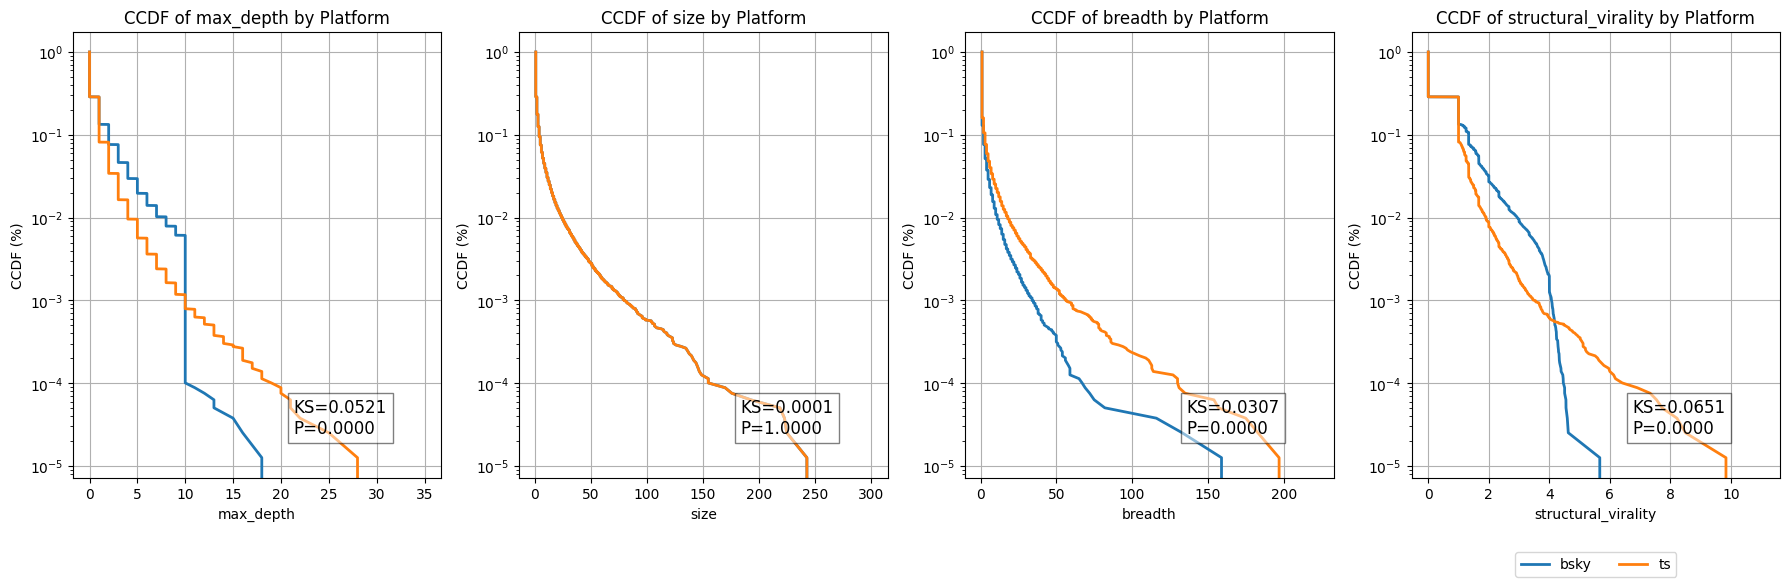

In [27]:
# Plot CCDF comparison by platform
fig, axes = plt.subplots(1, 4, figsize=(18, 6))  # 1 row, 3 columns

for idx, metric in enumerate(metrics):
    for platform in ["bsky", "ts"]:
        values = df[df["platform"] == platform][metric].dropna()
        sorted_vals = np.sort(values)
        ccdf = 1 - np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
        axes[idx].plot(sorted_vals, ccdf, label=f"{platform}", linewidth=2)

    # if metric != "structural_virality":
    #    axes[idx].set_xscale("log")  # Apply log scale to x-axis
    axes[idx].set_yscale("log")  # Keep y-axis in log scale
    axes[idx].set_xlabel(metric)
    axes[idx].set_ylabel("CCDF (%)")
    axes[idx].set_title(f"CCDF of {metric} by Platform")
    axes[idx].grid()

    # Retrieve KS statistic and p-value
    ks_stat, p_value = ks_overall_df.loc[
        ks_overall_df["Metric"] == metric, ["KS Statistic", "P-value"]
    ].values[0]
    axes[idx].text(
        0.6,
        0.1,
        f"KS={ks_stat:.4f}\nP={p_value:.4f}",
        transform=axes[idx].transAxes,
        fontsize=12,
        bbox=dict(facecolor="white", alpha=0.5),
    )

plt.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2
)  # Move legend outside
plt.tight_layout()
plt.show()

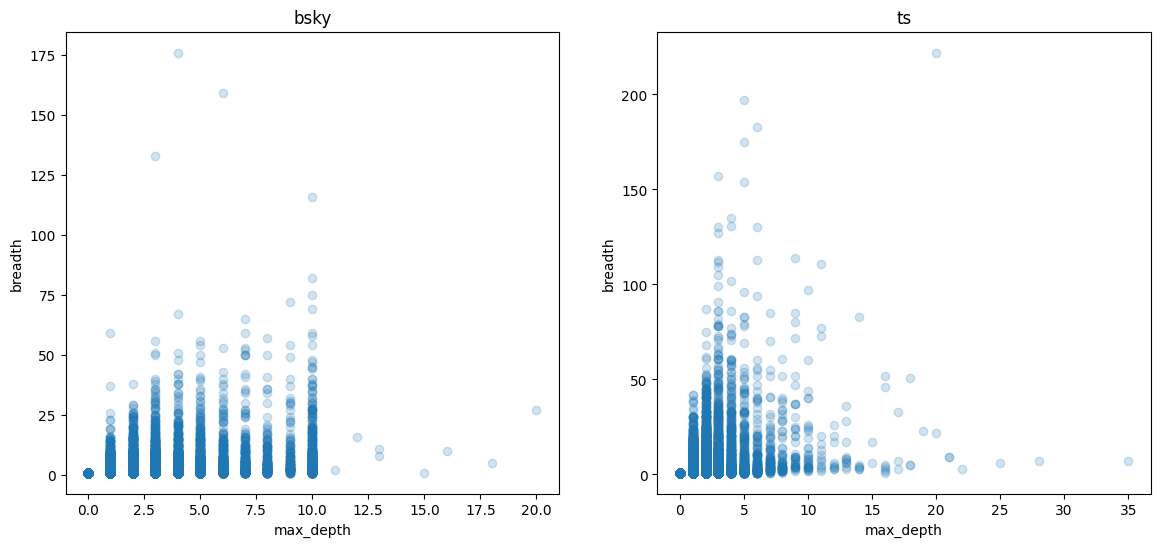

In [28]:
# plot the max depth and mean breadth of the reply

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].scatter(bsky_df["max_depth"], bsky_df["breadth"], label="bsky", alpha=0.2)
axes[1].scatter(
    sampled_ts_df["max_depth"], sampled_ts_df["breadth"], label="ts", alpha=0.2
)
axes[0].set_xlabel("max_depth")
axes[0].set_ylabel("breadth")
axes[1].set_xlabel("max_depth")
axes[1].set_ylabel("breadth")
axes[0].set_title("bsky")
axes[1].set_title("ts")
plt.show()


In [32]:
import numpy as np
import pandas as pd
import random
from collections import defaultdict

# Sort rp_ts_df by size for efficient binary search
rp_ts_df = rp_ts_df.sort_values("size").reset_index(drop=True)
rp_bsky_df = rp_bsky_df.sort_values("size").reset_index(drop=True)

# Convert DataFrames to NumPy arrays for fast operations
bsky_sizes = rp_bsky_df["size"].to_numpy()
ts_sizes = rp_ts_df["size"].to_numpy()
ts_indices = rp_ts_df.index.to_numpy()  # Store original indices

# Store indices of matched records instead of full row data
matched_indices = []
unmatched_size = set()

# Track available indices for each size (handles duplicates)
size_to_indices = defaultdict(list)
for i, size in enumerate(ts_sizes):
    size_to_indices[size].append(ts_indices[i])  # Store index for sampling

# Fast lookup using NumPy binary search
for size in bsky_sizes:
    idx = np.searchsorted(ts_sizes, size)  # Find closest match index

    # Get nearest neighbor within tolerance
    possible_matches = size_to_indices.get(ts_sizes[idx], [])

    # If valid matches are found, sample one
    if possible_matches:
        matched_indices.append(
            random.choice(possible_matches)
        )  # Randomly sample one index
    else:
        unmatched_size.add(size)

# Reconstruct the final DataFrame using the sampled indices
sampled_rp_ts_df = (
    rp_ts_df.loc[matched_indices].reset_index(drop=True)
    if matched_indices
    else pd.DataFrame()
)


In [30]:
sampled_rp_ts_df.drop_duplicates(inplace=True)

In [33]:
sampled_rp_ts_df.shape

(195616, 13)

In [34]:
# Select relevant columns
columns_to_keep = [
    "platform",
    "topic_label",
    "max_depth",
    "size",
    "breadth",
    "structural_virality",
]  # Removed 'structural_virality'
rp_bsky_df = rp_bsky_df[columns_to_keep].reset_index(drop=True)
sampled_rp_ts_df = sampled_rp_ts_df[columns_to_keep].reset_index(drop=True)

rp_df = pd.concat([rp_bsky_df, sampled_rp_ts_df], ignore_index=True)
rp_df = rp_df.dropna(subset=["topic_label"])
print(len(rp_df))


391225


In [35]:
# Compute KS statistics for each metric
ks_results = []
metrics = ["max_depth", "size", "breadth", "structural_virality"]
for metric in metrics:
    bsky_vals = rp_df[rp_df["platform"] == "bsky"][metric].dropna()
    ts_vals = rp_df[rp_df["platform"] == "ts"][metric].dropna()
    ks_stat, p_value = ks_2samp(bsky_vals, ts_vals)
    ks_results.append({"Metric": metric, "KS Statistic": ks_stat, "P-value": p_value})

ks_overall_df = pd.DataFrame(ks_results)


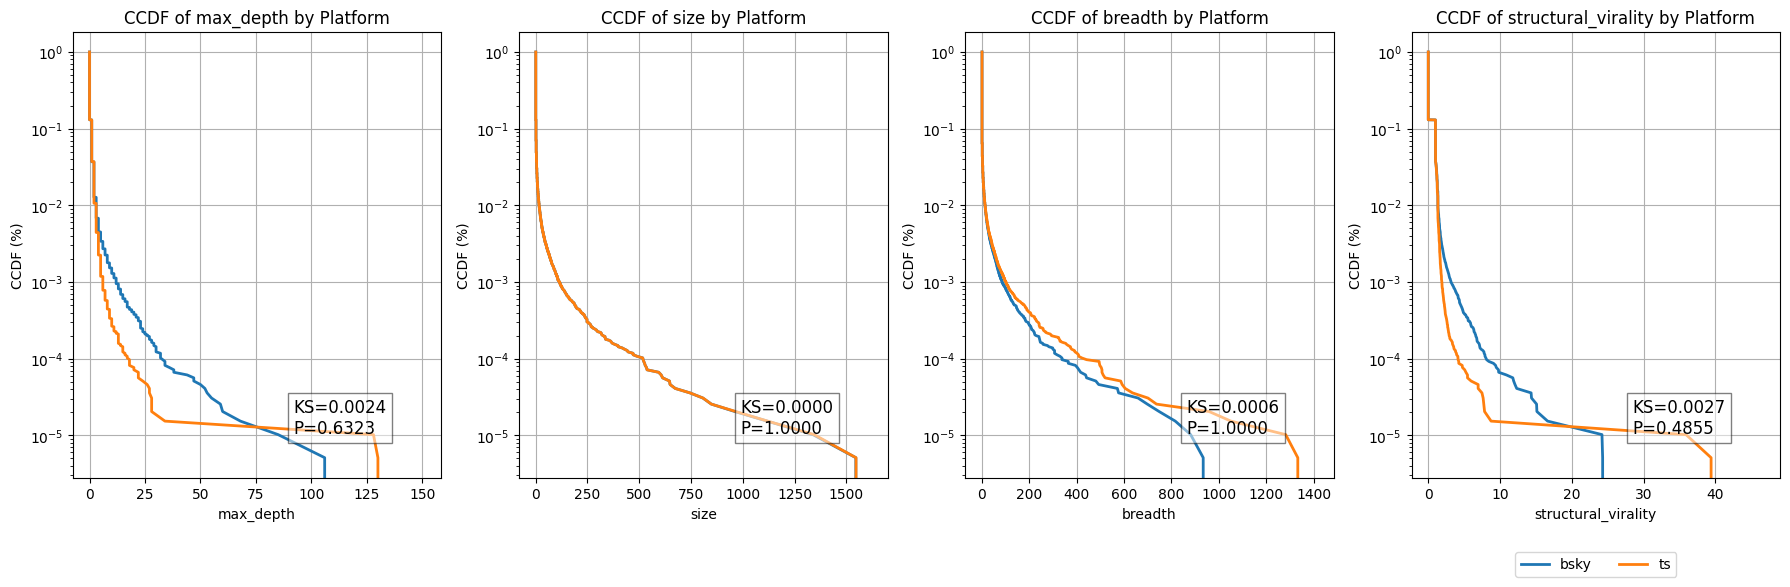

In [36]:
# Plot CCDF comparison by platform
fig, axes = plt.subplots(1, 4, figsize=(18, 6))  # 1 row, 3 columns

for idx, metric in enumerate(metrics):
    for platform in ["bsky", "ts"]:
        values = rp_df[rp_df["platform"] == platform][metric].dropna()
        sorted_vals = np.sort(values)
        ccdf = 1 - np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
        axes[idx].plot(sorted_vals, ccdf, label=f"{platform}", linewidth=2)

    # if metric != "structural_virality":
    # axes[idx].set_xscale("log")  # Apply log scale to x-axis
    axes[idx].set_yscale("log")  # Keep y-axis in log scale
    axes[idx].set_xlabel(metric)
    axes[idx].set_ylabel("CCDF (%)")
    axes[idx].set_title(f"CCDF of {metric} by Platform")
    axes[idx].grid()

    # Retrieve KS statistic and p-value
    ks_stat, p_value = ks_overall_df.loc[
        ks_overall_df["Metric"] == metric, ["KS Statistic", "P-value"]
    ].values[0]
    axes[idx].text(
        0.6,
        0.1,
        f"KS={ks_stat:.4f}\nP={p_value:.4f}",
        transform=axes[idx].transAxes,
        fontsize=12,
        bbox=dict(facecolor="white", alpha=0.5),
    )

plt.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2
)  # Move legend outside
plt.tight_layout()
plt.show()


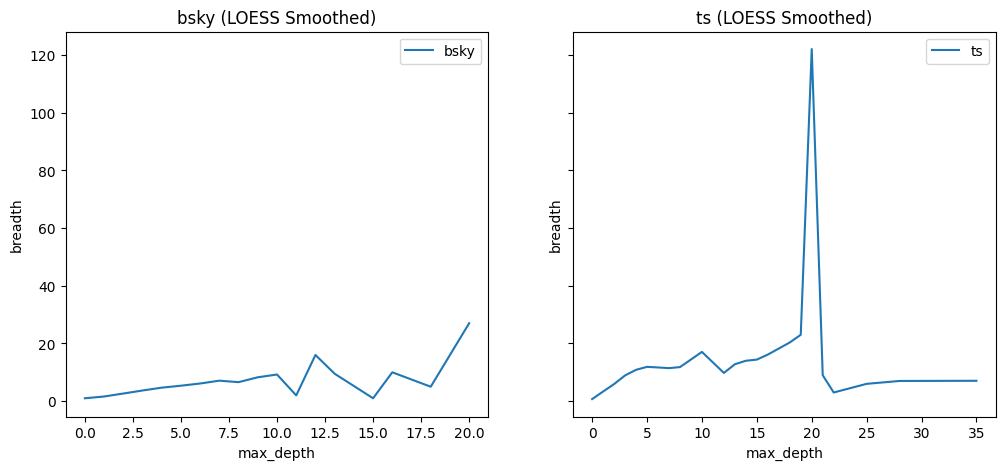

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# Assuming 'df' is your DataFrame with 'max_depth', 'breadth', and 'platform' columns
df_bsky = df[df["platform"] == "bsky"]
df_ts = df[df["platform"] == "ts"]

# Compute the mean breadth for each max_depth
bsky_grouped = df_bsky.groupby("max_depth")["breadth"].mean().reset_index()
ts_grouped = df_ts.groupby("max_depth")["breadth"].mean().reset_index()

# Apply LOWESS smoothing (fraction controls smoothing level)
frac = 0.2  # Adjust fraction for smoother or sharper fit
bsky_smooth = lowess(bsky_grouped["breadth"], bsky_grouped["max_depth"], frac=frac)
ts_smooth = lowess(ts_grouped["breadth"], ts_grouped["max_depth"], frac=frac)

# Plot the smoothed data
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axes[0].plot(bsky_smooth[:, 0], bsky_smooth[:, 1], linestyle="-", label="bsky")
axes[1].plot(ts_smooth[:, 0], ts_smooth[:, 1], linestyle="-", label="ts")

# Titles and labels
axes[0].set_title("bsky (LOESS Smoothed)")
axes[1].set_title("ts (LOESS Smoothed)")

for ax in axes:
    ax.set_xlabel("max_depth")
    ax.set_ylabel("breadth")
    ax.legend()

plt.show()


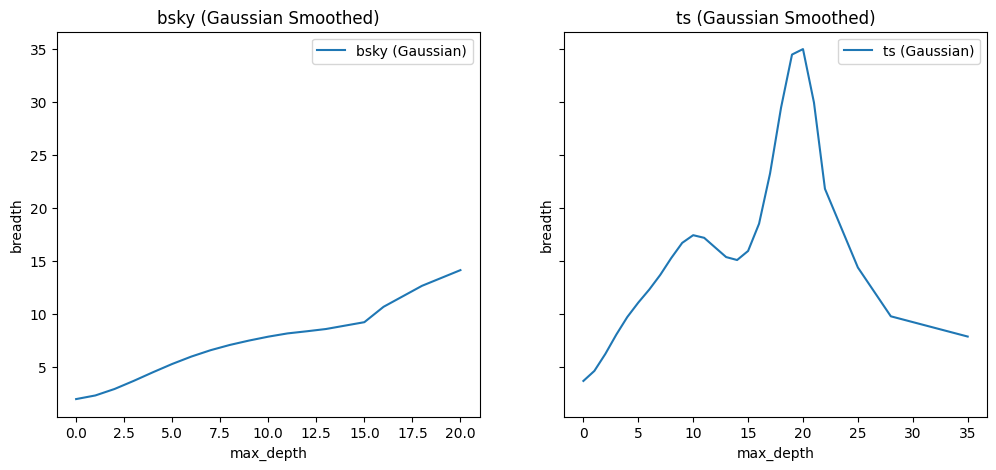

In [38]:
from scipy.ndimage import gaussian_filter1d

# Apply Gaussian smoothing to the grouped means
bsky_smooth_gauss = gaussian_filter1d(bsky_grouped["breadth"], sigma=2)
ts_smooth_gauss = gaussian_filter1d(ts_grouped["breadth"], sigma=2)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axes[0].plot(
    bsky_grouped["max_depth"], bsky_smooth_gauss, linestyle="-", label="bsky (Gaussian)"
)
axes[1].plot(
    ts_grouped["max_depth"], ts_smooth_gauss, linestyle="-", label="ts (Gaussian)"
)

# Titles and labels
axes[0].set_title("bsky (Gaussian Smoothed)")
axes[1].set_title("ts (Gaussian Smoothed)")

for ax in axes:
    ax.set_xlabel("max_depth")
    ax.set_ylabel("breadth")
    ax.legend()

plt.show()


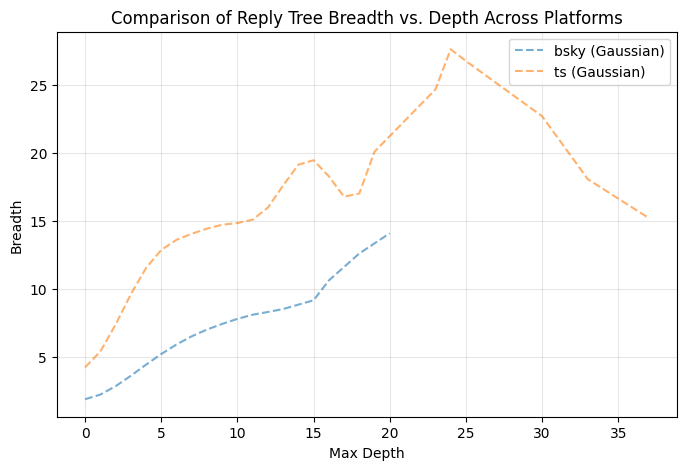

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.ndimage import gaussian_filter1d

# Assuming 'df' is your DataFrame with 'max_depth', 'breadth', and 'platform' columns
df_bsky = df[df["platform"] == "bsky"]
df_ts = df[df["platform"] == "ts"]

# Compute mean breadth per max_depth
bsky_grouped = df_bsky.groupby("max_depth")["breadth"].mean().reset_index()
ts_grouped = df_ts.groupby("max_depth")["breadth"].mean().reset_index()

# Apply LOESS smoothing
frac = 0.2  # Adjust fraction for smoother or sharper fit
bsky_loess = lowess(bsky_grouped["breadth"], bsky_grouped["max_depth"], frac=frac)
ts_loess = lowess(ts_grouped["breadth"], ts_grouped["max_depth"], frac=frac)

# Apply Gaussian smoothing
bsky_gauss = gaussian_filter1d(bsky_grouped["breadth"], sigma=2)
ts_gauss = gaussian_filter1d(ts_grouped["breadth"], sigma=2)

# Plot both platforms on the same graph
plt.figure(figsize=(8, 5))

# LOESS Smoothed Lines
# plt.plot(bsky_loess[:, 0], bsky_loess[:, 1], linestyle="-", label="bsky (LOESS)", alpha=0.8)
# plt.plot(ts_loess[:, 0], ts_loess[:, 1], linestyle="-", label="ts (LOESS)", alpha=0.8)

# Gaussian Smoothed Lines (dashed for distinction)
plt.plot(
    bsky_grouped["max_depth"],
    bsky_gauss,
    linestyle="--",
    label="bsky (Gaussian)",
    alpha=0.6,
)
plt.plot(
    ts_grouped["max_depth"], ts_gauss, linestyle="--", label="ts (Gaussian)", alpha=0.6
)

# Labels and title
plt.xlabel("Max Depth")
plt.ylabel("Breadth")
plt.title("Comparison of Reply Tree Breadth vs. Depth Across Platforms")
plt.legend()
plt.grid(alpha=0.3)

plt.show()


# E. Normalization

## 1. Normalize the depth and width of the cascades by its size

In [ ]:
bsky_df["bredth_normalized"] = bsky_df["breadth"] / bsky_df["size"]
ts_df["bredth_normalized"] = ts_df["breadth"] / ts_df["size"]
rp_bsky_df["bredth_normalized"] = rp_bsky_df["breadth"] / rp_bsky_df["size"]
rp_ts_df["bredth_normalized"] = rp_ts_df["breadth"] / rp_ts_df["size"]

bsky_df["deepth_normalized"] = bsky_df["max_depth"] / bsky_df["size"]
ts_df["deepth_normalized"] = ts_df["max_depth"] / ts_df["size"]
rp_bsky_df["deepth_normalized"] = rp_bsky_df["max_depth"] / rp_bsky_df["size"]
rp_ts_df["deepth_normalized"] = rp_ts_df["max_depth"] / rp_ts_df["size"]


In [17]:
sum(df["size"] == 1)

75526

In [ ]:
sum(df_rp["size"] == 1)

1321200

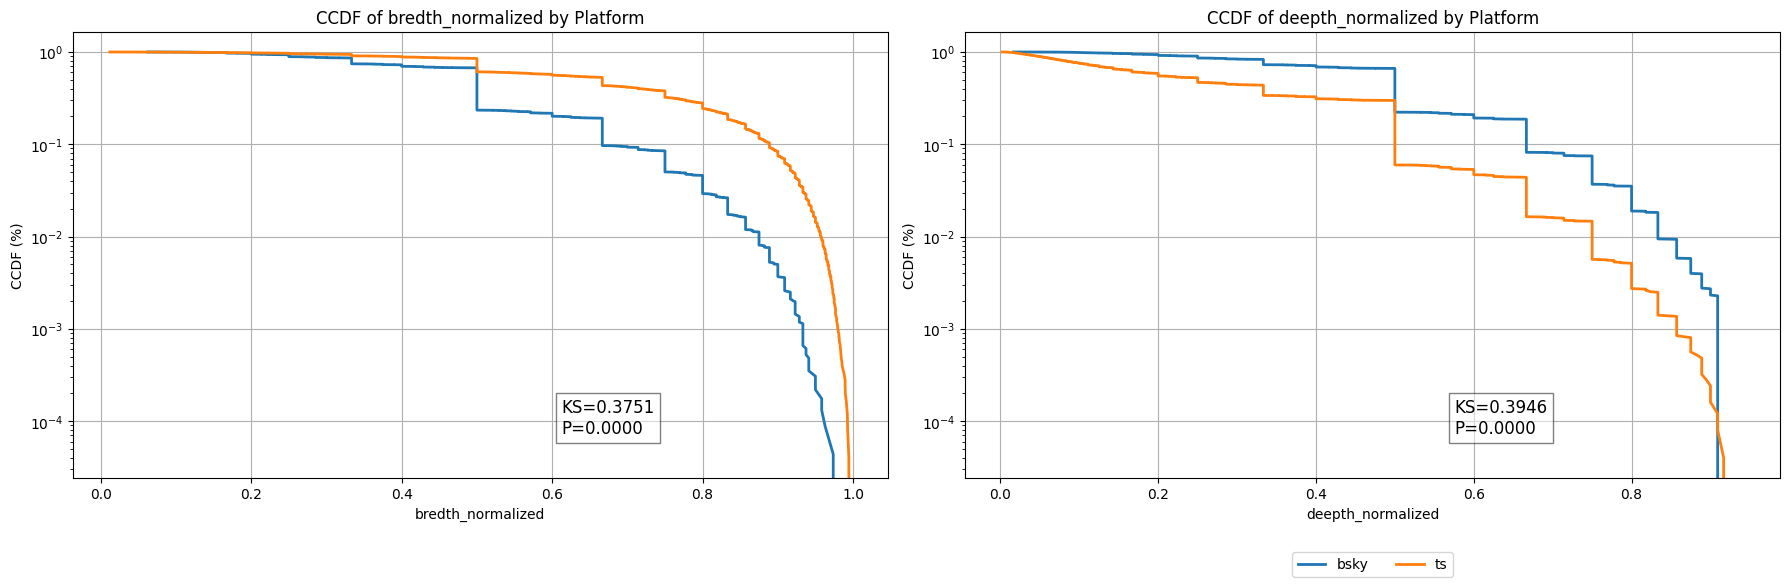

In [21]:
df = pd.concat([bsky_df, ts_df], ignore_index=True)
df = df.loc[df["size"] > 1]
# Compute KS statistics for each metric
ks_results = []
metrics = ["bredth_normalized", "deepth_normalized"]
for metric in metrics:
    bsky_vals = df[df["platform"] == "bsky"][metric].dropna()
    ts_vals = df[df["platform"] == "ts"][metric].dropna()
    ks_stat, p_value = ks_2samp(bsky_vals, ts_vals)
    ks_results.append({"Metric": metric, "KS Statistic": ks_stat, "P-value": p_value})

ks_overall_df = pd.DataFrame(ks_results)
# plot the ccdf of nomalized bredth and deepth
# Plot CCDF comparison by platform

fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 3 columns

for idx, metric in enumerate(["bredth_normalized", "deepth_normalized"]):
    for platform in ["bsky", "ts"]:
        values = df[df["platform"] == platform][metric].dropna()
        sorted_vals = np.sort(values)
        ccdf = 1 - np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
        axes[idx].plot(sorted_vals, ccdf, label=f"{platform}", linewidth=2)

    # if metric != "structural_virality":
    # axes[idx].set_xscale("log")  # Apply log scale to x-axis
    axes[idx].set_yscale("log")  # Keep y-axis in log scale
    axes[idx].set_xlabel(metric)
    axes[idx].set_ylabel("CCDF (%)")
    axes[idx].set_title(f"CCDF of {metric} by Platform")
    axes[idx].grid()

    # Retrieve KS statistic and p-value
    ks_stat, p_value = ks_overall_df.loc[
        ks_overall_df["Metric"] == metric, ["KS Statistic", "P-value"]
    ].values[0]
    axes[idx].text(
        0.6,
        0.1,
        f"KS={ks_stat:.4f}\nP={p_value:.4f}",
        transform=axes[idx].transAxes,
        fontsize=12,
        bbox=dict(facecolor="white", alpha=0.5),
    )

plt.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2
)  # Move legend outside
plt.tight_layout()
plt.show()

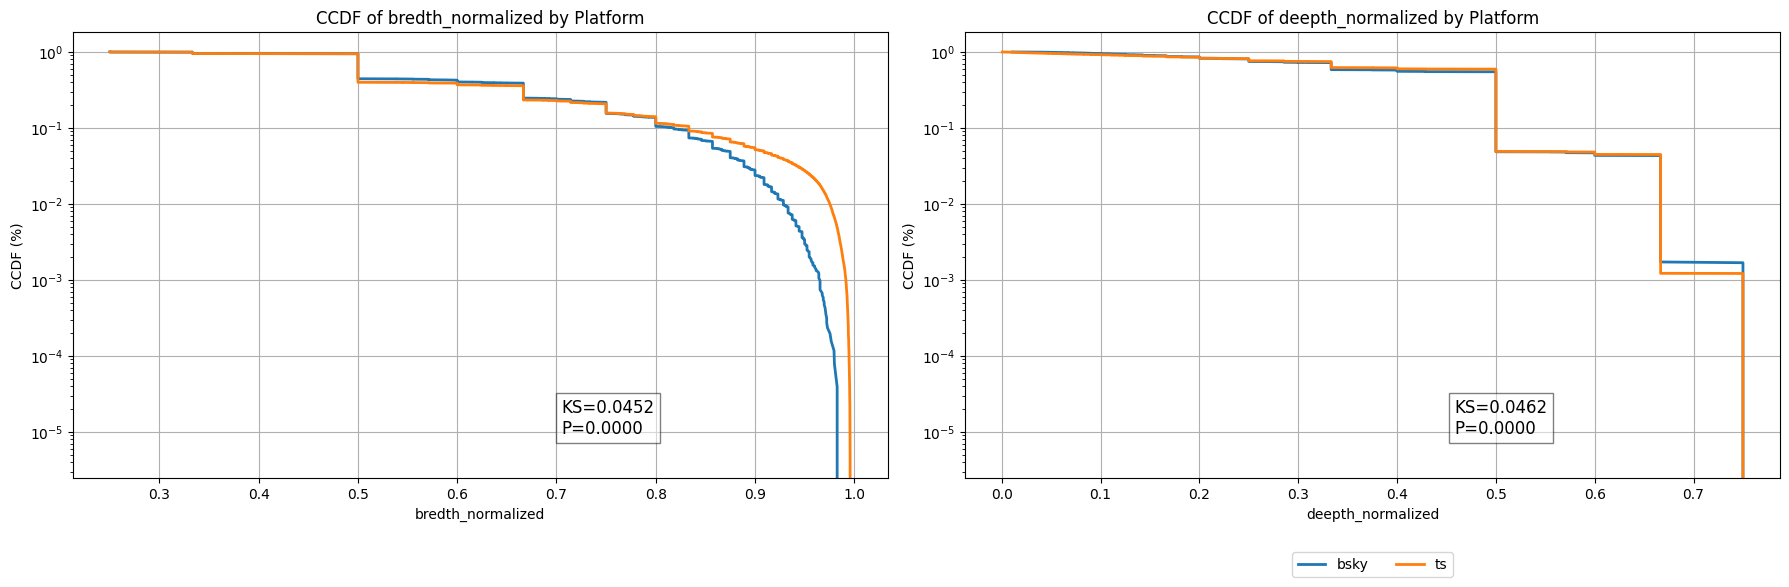

In [20]:
# for repost
df_rp = pd.concat([rp_bsky_df, rp_ts_df], ignore_index=True)
df_rp = df_rp.loc[df_rp["size"] > 1]
# compute ks statistics for each metric
ks_results = []
metrics = ["bredth_normalized", "deepth_normalized"]
for metric in metrics:
    bsky_vals = df_rp[df_rp["platform"] == "bsky"][metric].dropna()
    ts_vals = df_rp[df_rp["platform"] == "ts"][metric].dropna()
    ks_stat, p_value = ks_2samp(bsky_vals, ts_vals)
    ks_results.append({"Metric": metric, "KS Statistic": ks_stat, "P-value": p_value})

ks_overall_df = pd.DataFrame(ks_results)

# plot the ccdf of nomalized bredth and deepth
# Plot CCDF comparison by platform
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 3 columns

for idx, metric in enumerate(["bredth_normalized", "deepth_normalized"]):
    for platform in ["bsky", "ts"]:
        values = df_rp[df_rp["platform"] == platform][metric].dropna()
        sorted_vals = np.sort(values)
        ccdf = 1 - np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
        axes[idx].plot(sorted_vals, ccdf, label=f"{platform}", linewidth=2)

    # if metric != "structural_virality":
    # axes[idx].set_xscale("log")  # Apply log scale to x-axis
    axes[idx].set_yscale("log")  # Keep y-axis in log scale
    axes[idx].set_xlabel(metric)
    axes[idx].set_ylabel("CCDF (%)")
    axes[idx].set_title(f"CCDF of {metric} by Platform")
    axes[idx].grid()

    # Retrieve KS statistic and p-value
    ks_stat, p_value = ks_overall_df.loc[
        ks_overall_df["Metric"] == metric, ["KS Statistic", "P-value"]
    ].values[0]
    axes[idx].text(
        0.6,
        0.1,
        f"KS={ks_stat:.4f}\nP={p_value:.4f}",
        transform=axes[idx].transAxes,
        fontsize=12,
        bbox=dict(facecolor="white", alpha=0.5),
    )

plt.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2
)  # Move legend outside
plt.tight_layout()
plt.show()